In [18]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
torch.manual_seed(0)
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.figsize'] = [6, 6]

In [19]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=300, trange=2):
    #initialize xrange
    if xrange is None:
        xrange = [-pi, 3 * pi]

    # define an interval
    inter = trange/300
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval = inter)]
    
    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-5)
    
    return field, storage

In [20]:
s1, st1 = solveEquationPYPDE('phi', f"- 6 * phi * d_dx(phi) - laplace(d_dx(phi))")

100%|███████████████████████████████████████████████████████████████████████████████| 2.0/2.0 [00:18<00:00,  9.19s/it]


(301, 300)


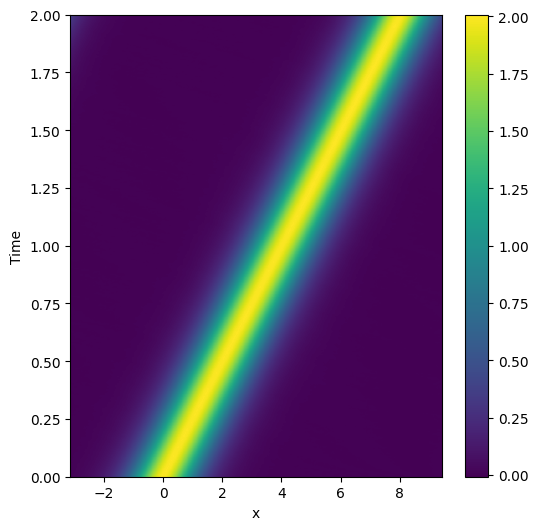

In [21]:
print(np.array(st1.data).shape)
pde.plot_kymograph(st1)

In [22]:
numerical = np.array(st1.data)[:300,:]

In [23]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)[:300, :]

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 100, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 105, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, phi_train = gen_train(x_grid), gen_train(t_grid), gen_train(phi)

In [24]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

phi_train = phi_train.flatten()[:,None]
print(x_train.shape, t_train.shape, phi_train.shape)

(10500, 1) (10500, 1) (10500, 1)


In [25]:
def preds_and_errors(model, err=1):
    #with torch.cuda.amp.autocast():
    pred = model.net(xt_pairs).reshape((300,300)).detach().cpu()
    
    #absval = torch.sqrt(pred[:,0:1]**2 + pred[:,1:2]**2).reshape((100,100)).detach().cpu()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, layout='constrained')
    fig.set_figwidth(12)
    #fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Predicted")
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    p1 = ax1.pcolormesh(x_grid.numpy(), t_grid.numpy(), pred.numpy())
    plt.colorbar(p1, ax=ax1)
    ax2.set_title("Error")
    ax2.set_xlabel("x")
    p2 = ax2.pcolormesh(x_grid.numpy(), t_grid.numpy(),  np.abs(pred.numpy()-numerical)/err)
    plt.colorbar(p2, ax=ax2)
    plt.show()

In [26]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-pi, 3 * pi, 300, dtype=torch.float32)##, dtype=torch.float16)
t_axis = torch.linspace(0, 2, 300, dtype=torch.float32)##, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, phi, dDim=256, nHid=4, lr=1e-4, path=None):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device) ## dtype=torch.float16,
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device) ## dtype=torch.float16,
        
        self.phi = torch.tensor(phi, dtype=torch.float32, device=device) ##  dtype=torch.float16,
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float32, device=device) ##  dtype=torch.float16,

        self.dDim = dDim
        self.nHid = nHid
        self.lr = lr
        self.mse = torch.nn.MSELoss()
        
        ## Attempt to load the model
        if path:
            checkpoint = torch.load(path)
            ## Initialize the net and load the state_dict, same for the optimizer
            self.net_init()
            self.net.load_state_dict(checkpoint['model_state_dict'])
            
            self.lam1 = checkpoint['lam1']
            self.lam2 = checkpoint['lam2']
            self.lams1 = checkpoint['lams1']
            self.lams2 = checkpoint['lams2']
            self.optim = torch.optim.Adam(list(self.net.parameters()) + [self.lam1, self.lam2], lr=self.lr)
            self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss_history']
            self.ls = checkpoint['loss_val']
            self.step = checkpoint['step']
        
        else:
            ##initialize the unknown coefficients
            self.lam1 = torch.nn.Parameter(torch.tensor(3, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
            self.lam2 = torch.nn.Parameter(torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
            self.lams1 = []
            self.lams2 = []
            
            self.net_init()
            #self.optim = torch.optim.LBFGS(self.net.parameters(),
            #                               lr=0.01,
            #                               max_iter=50000,
            #                               max_eval=50000,
            #                               history_size=50,
            #                               tolerance_grad=1e-8,
            #                               tolerance_change=0.5 * np.finfo(float).eps,
            #                               line_search_fn='strong_wolfe'
            #                              )
    
            self.optim = torch.optim.Adam(list(self.net.parameters()) + [self.lam1, self.lam2], lr=self.lr)
            
            self.loss = []
            self.ls = 0
            self.step = 0


    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 1)
        )

        for module in self.net.modules():
            if isinstance(module, act):
                module = torch.cuda.amp.autocast()(module)
        
        self.net.to(device)

    
    def func(self, x, t):
        ##with torch.cuda.amp.autocast():
        phi = self.net(torch.hstack((x, t)))

        phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
        phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
        phi_xx = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
        phi_xxx = torch.autograd.grad(phi_xx, x, torch.ones_like(phi_xx), create_graph=True)[0]

        ##f_phi = phi_t + self.lam1 * phi * phi_x + self.lam2 * phi_xxx
        f_phi = phi_t + self.lam1 * phi * phi_x + self.lam2 * phi_xxx
        return phi, f_phi
        
    def closure(self):
        ## with torch.cuda.amp.autocast(dtype=torch.float16):
        self.optim.zero_grad(set_to_none=True)
        phi_pred, f_phi_pred = self.func(self.x, self.t)
        phi_loss = self.mse(phi_pred, self.phi)
        f_phi_loss = self.mse(f_phi_pred, self.null)
        self.ls = phi_loss + f_phi_loss
        self.ls.backward()

        if not self.step % 250:
            print(f"Step: {self.step}, Loss: {self.ls}")
            print(f"Data loss: {phi_loss}, Phi loss: {f_phi_loss}")
            print(f"Lam1: {round(self.lam1.item(),4)}, lam2: {round(self.lam2.item(),4)}")
        
        if not self.step % 5000:
            preds_and_errors(self)
            f, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
            ax1.plot(self.lams1)
            ax1.set_title('lam1')
            ax2.plot(self.lams2)
            ax2.set_title('lam2')
            plt.show()
            plt.plot(self.loss)
            plt.show()

        self.loss.append(self.ls.item())
        self.lams1.append(self.lam1.item())
        self.lams2.append(self.lam2.item())
        self.step += 1
        return self.ls

    def train(self, steps):
        self.net.train()
        for i in range(steps):
            self.optim.step(self.closure)
    
    def save(self):
        torch.save({
                'step': self.step,
                'model_state_dict': self.net.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                'loss_val': self.ls,
                'loss_history': self.loss,
                'lam1': self.lam1,
                'lam2': self.lam2,
                'lams1': self.lams1,
                'lams2': self.lams2
                }, f'/home/gallirium/diplom/models_kdv/model_kdv_{self.step}.pt')

In [16]:
kdv = PINN(x_train, t_train, phi_train, nHid=8, dDim=128, lr=5e-5, path='/home/gallirium/diplom/models_kdv/model_kdv_375000.pt')

/home/gallirium/dostNN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step: 400000, Loss: 2.0558785763569176e-05
Data loss: 1.6571882952121086e-05, Phi loss: 3.9869037209427916e-06
Lam1: 5.9956, lam2: 0.9991


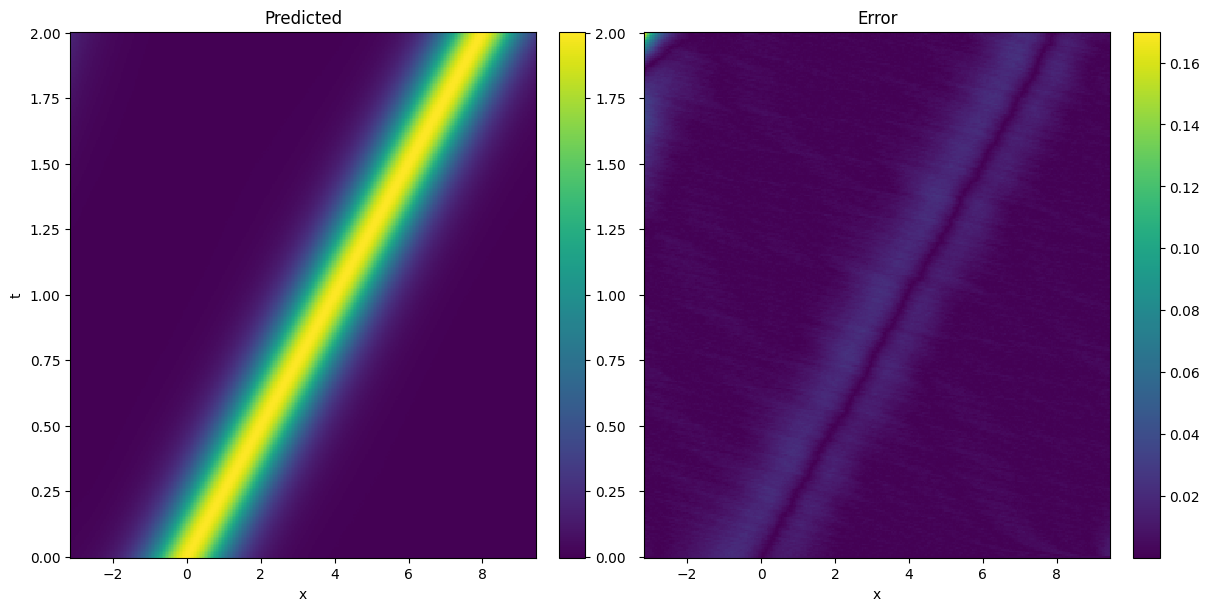

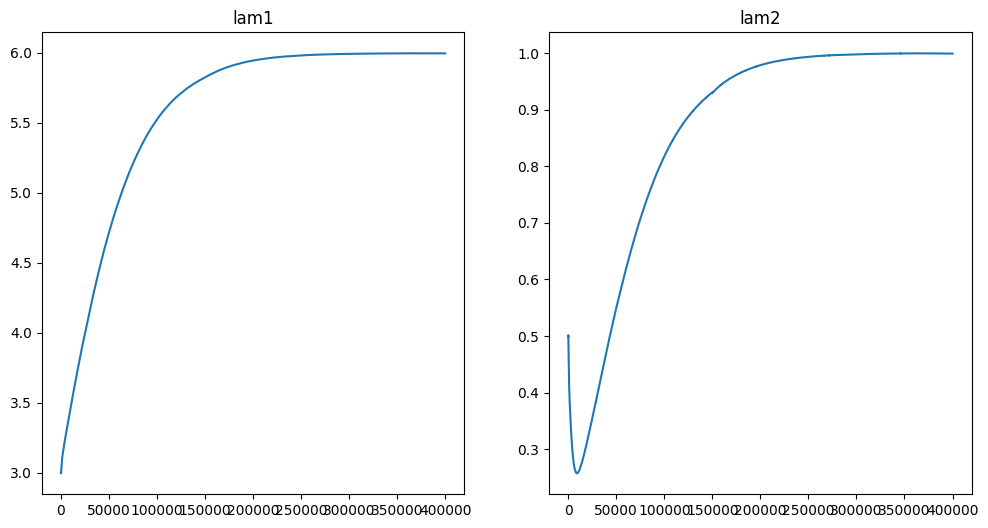

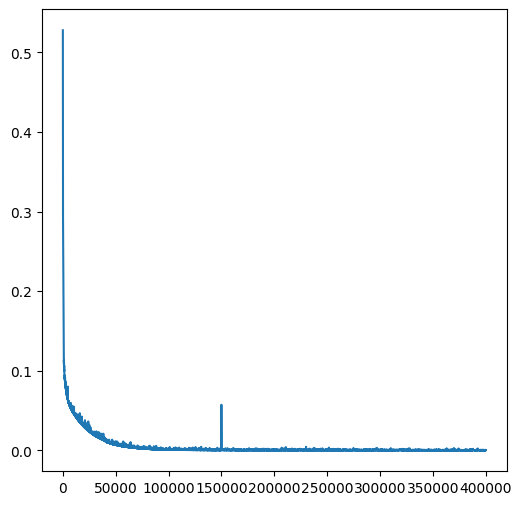

Step: 400250, Loss: 5.702165435650386e-05
Data loss: 2.1164647478144616e-05, Phi loss: 3.585700687835924e-05
Lam1: 5.9956, lam2: 0.9991
Step: 400500, Loss: 1.9466146113700233e-05
Data loss: 1.6271596905426122e-05, Phi loss: 3.194549208274111e-06
Lam1: 5.9956, lam2: 0.9991
Step: 400750, Loss: 1.937052365974523e-05
Data loss: 1.6047797544160858e-05, Phi loss: 3.322725433463347e-06
Lam1: 5.9956, lam2: 0.9991
Step: 401000, Loss: 4.0401064325124025e-05
Data loss: 1.676965257502161e-05, Phi loss: 2.3631409931113012e-05
Lam1: 5.9956, lam2: 0.9991
Step: 401250, Loss: 6.605036469409242e-05
Data loss: 1.6963464076980017e-05, Phi loss: 4.9086898798123e-05
Lam1: 5.9956, lam2: 0.9991
Step: 401500, Loss: 2.0366038370411843e-05
Data loss: 1.5845616871956736e-05, Phi loss: 4.520421043707756e-06
Lam1: 5.9956, lam2: 0.9991
Step: 401750, Loss: 6.897807907080278e-05
Data loss: 2.05114483833313e-05, Phi loss: 4.846663068747148e-05
Lam1: 5.9955, lam2: 0.9991
Step: 402000, Loss: 2.0008654246339574e-05
Data l

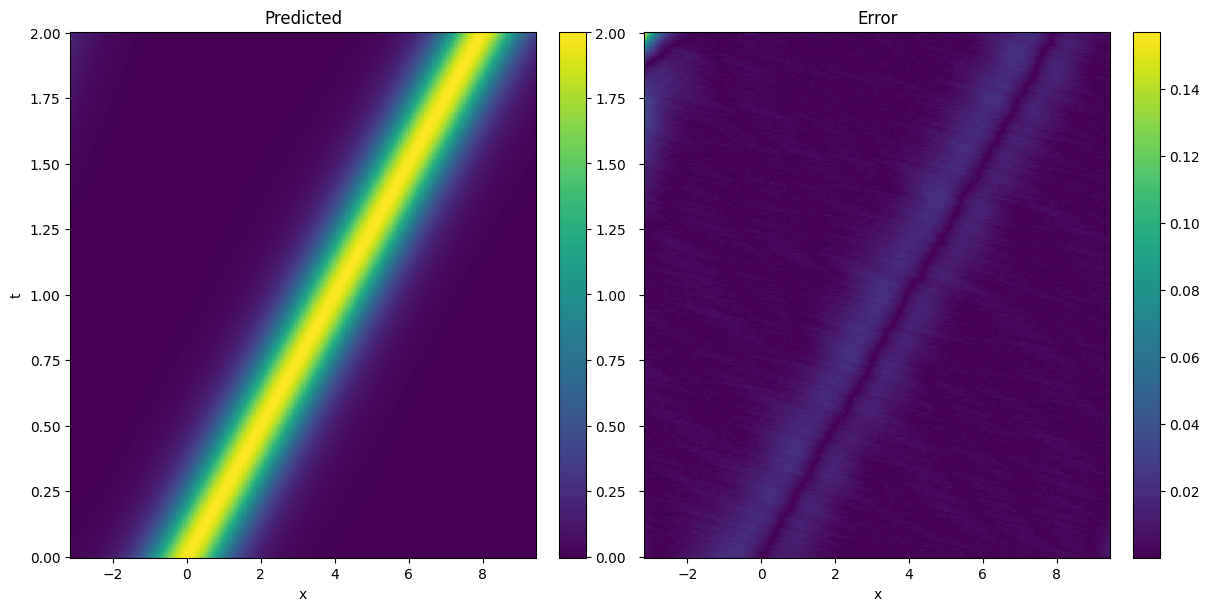

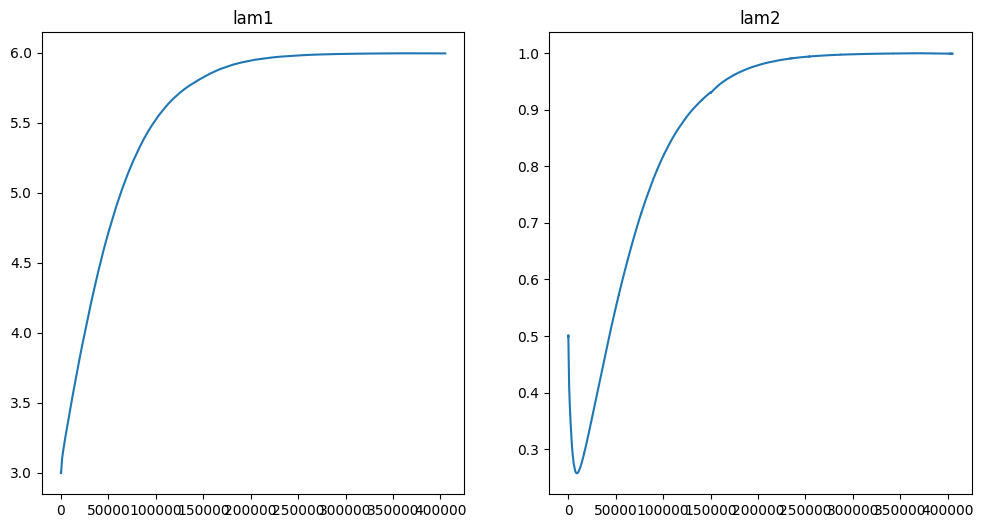

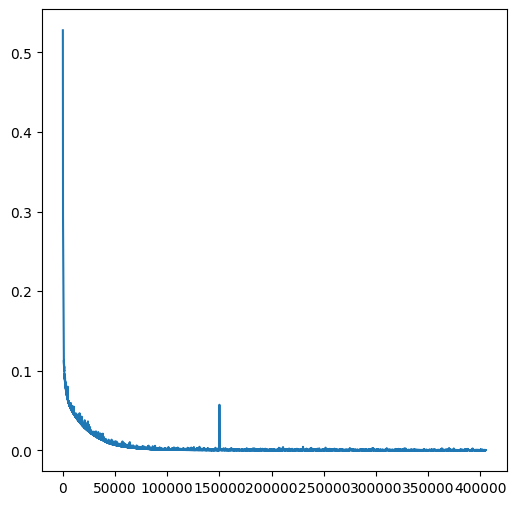

Step: 405250, Loss: 1.8024864402832463e-05
Data loss: 1.4305051990959328e-05, Phi loss: 3.719811502378434e-06
Lam1: 5.9955, lam2: 0.9991
Step: 405500, Loss: 5.197802965994924e-05
Data loss: 1.7630483853281476e-05, Phi loss: 3.4347543987678364e-05
Lam1: 5.9954, lam2: 0.9991
Step: 405750, Loss: 5.086185410618782e-05
Data loss: 1.9846005670842715e-05, Phi loss: 3.101585025433451e-05
Lam1: 5.9954, lam2: 0.9991
Step: 406000, Loss: 2.224922354798764e-05
Data loss: 1.4285794350143988e-05, Phi loss: 7.963429197843652e-06
Lam1: 5.9954, lam2: 0.9991
Step: 406250, Loss: 3.6347293644212186e-05
Data loss: 1.5864648958086036e-05, Phi loss: 2.0482642867136747e-05
Lam1: 5.9954, lam2: 0.999
Step: 406500, Loss: 2.2863392587169074e-05
Data loss: 1.4343261682370212e-05, Phi loss: 8.520130904798862e-06
Lam1: 5.9954, lam2: 0.999
Step: 406750, Loss: 4.0061833715299144e-05
Data loss: 1.4485724932455923e-05, Phi loss: 2.557610787334852e-05
Lam1: 5.9954, lam2: 0.999
Step: 407000, Loss: 3.813689181697555e-05
Dat

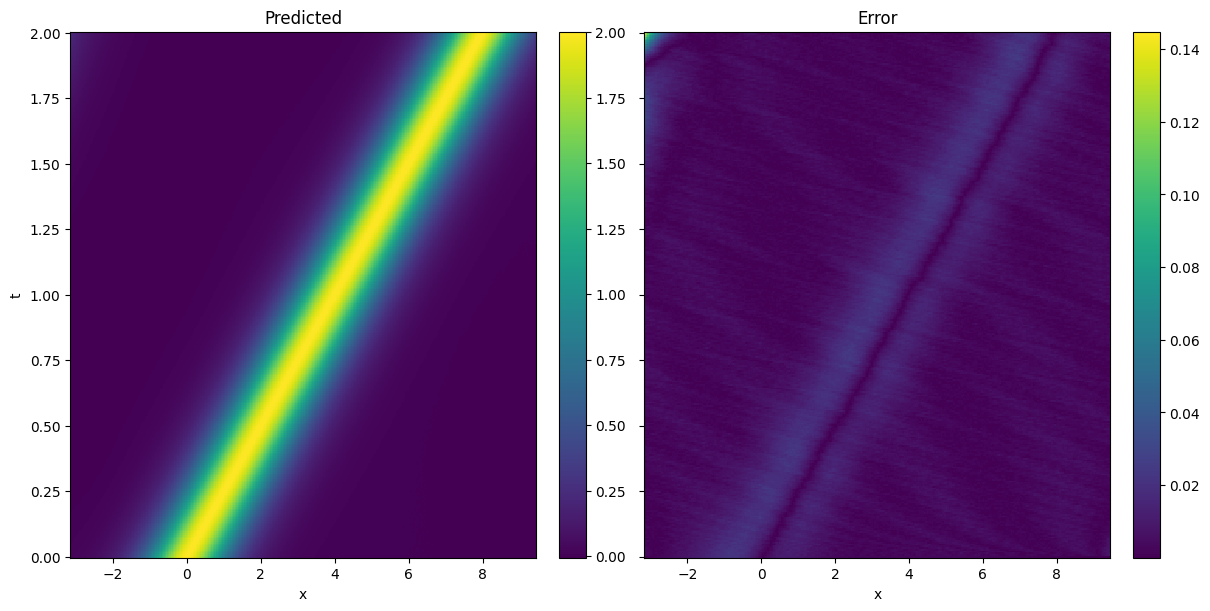

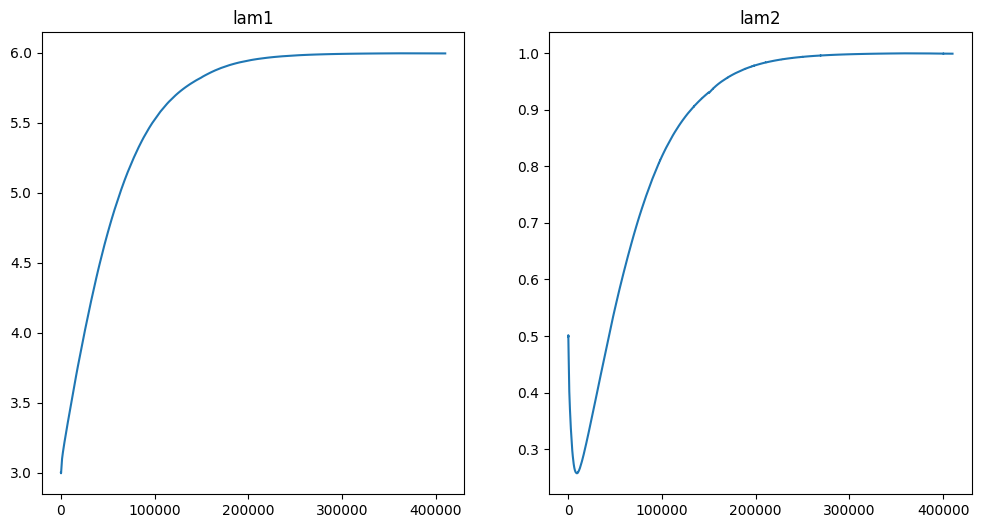

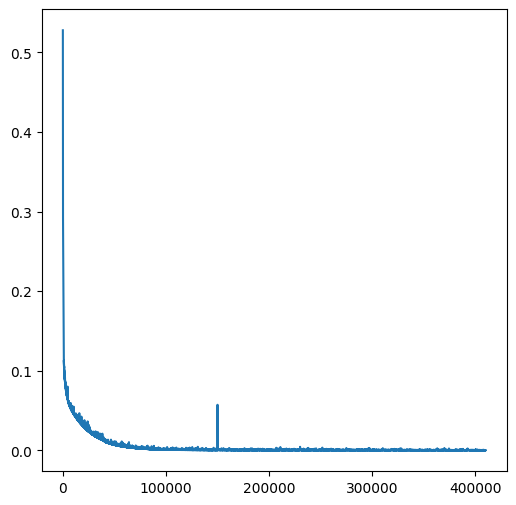

Step: 410250, Loss: 0.0003905131306964904
Data loss: 2.072888491966296e-05, Phi loss: 0.00036978424759581685
Lam1: 5.9953, lam2: 0.999
Step: 410500, Loss: 2.6553079806035385e-05
Data loss: 1.2430661627149675e-05, Phi loss: 1.412241817888571e-05
Lam1: 5.9953, lam2: 0.999
Step: 410750, Loss: 2.358746132813394e-05
Data loss: 1.2113418051740155e-05, Phi loss: 1.1474043276393786e-05
Lam1: 5.9953, lam2: 0.999
Step: 411000, Loss: 2.4449060219922103e-05
Data loss: 1.2288664038351271e-05, Phi loss: 1.2160396181570832e-05
Lam1: 5.9953, lam2: 0.999
Step: 411250, Loss: 3.085297794314101e-05
Data loss: 1.3662880519405007e-05, Phi loss: 1.7190095604746602e-05
Lam1: 5.9953, lam2: 0.999
Step: 411500, Loss: 2.8916932933498174e-05
Data loss: 1.1894613635377027e-05, Phi loss: 1.7022319298121147e-05
Lam1: 5.9953, lam2: 0.999
Step: 411750, Loss: 2.7320842491462827e-05
Data loss: 1.4462559192907065e-05, Phi loss: 1.285828238906106e-05
Lam1: 5.9953, lam2: 0.999
Step: 412000, Loss: 6.786183803342283e-05
Data 

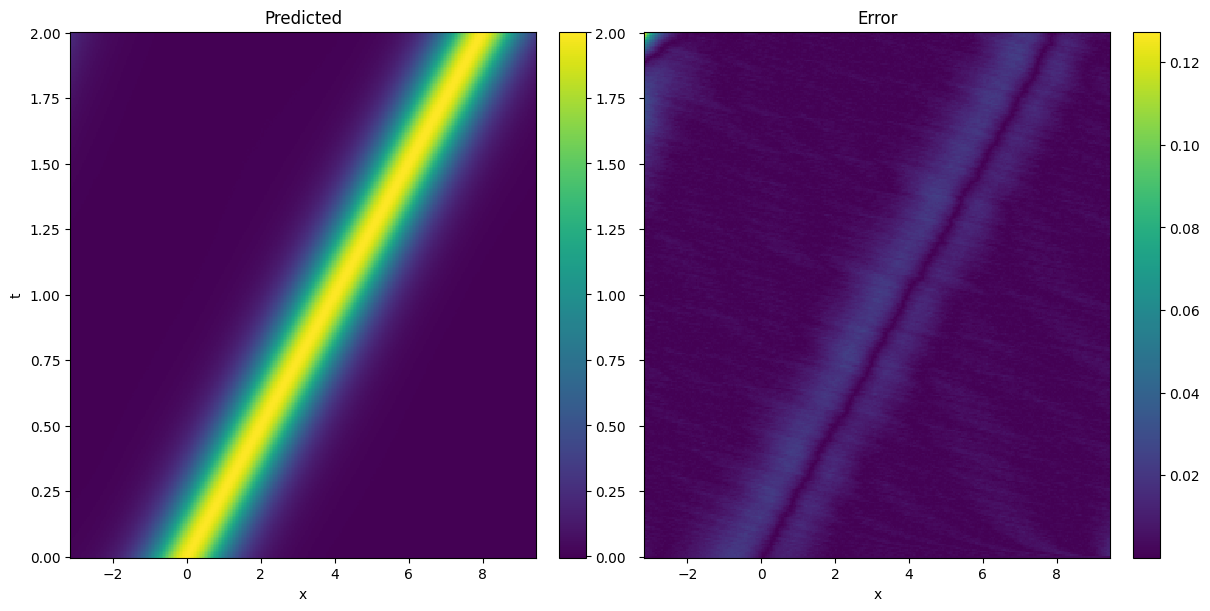

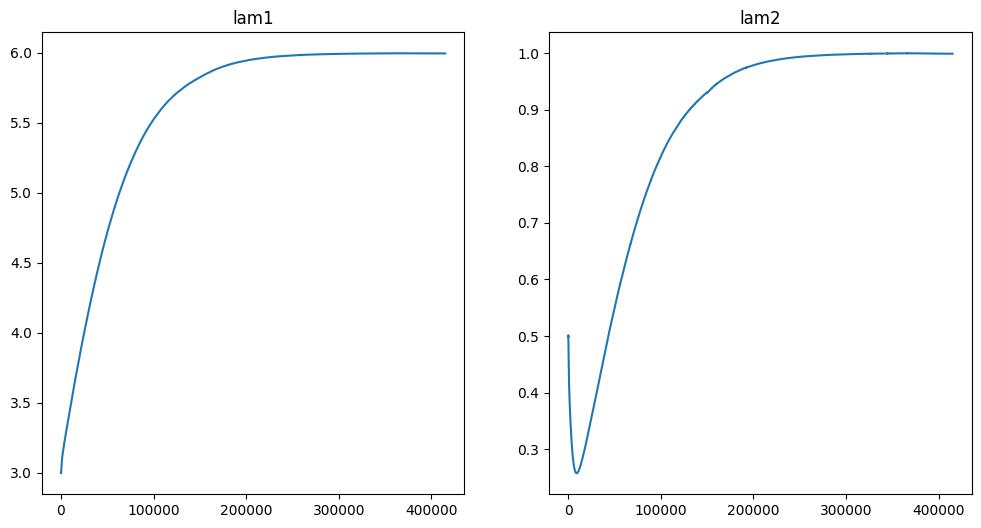

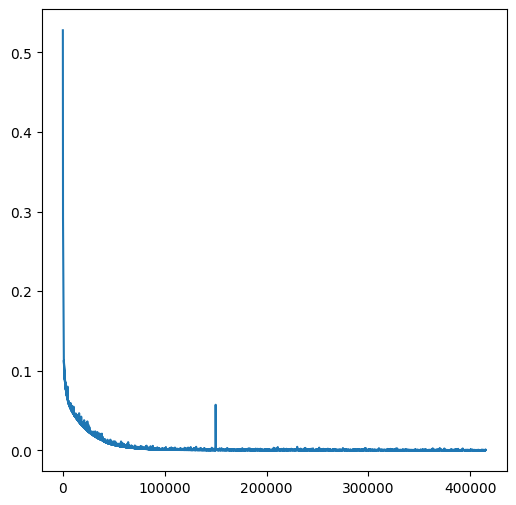

Step: 415250, Loss: 1.8006065147346817e-05
Data loss: 1.0579038644209504e-05, Phi loss: 7.427026048389962e-06
Lam1: 5.9952, lam2: 0.9989
Step: 415500, Loss: 1.5762983821332455e-05
Data loss: 1.0559818292676937e-05, Phi loss: 5.203165983402869e-06
Lam1: 5.9952, lam2: 0.9989
Step: 415750, Loss: 2.7392372430767864e-05
Data loss: 1.0906464922300074e-05, Phi loss: 1.6485906598973088e-05
Lam1: 5.9952, lam2: 0.9989
Step: 416000, Loss: 1.9182165488018654e-05
Data loss: 1.0766825653263368e-05, Phi loss: 8.415339834755287e-06
Lam1: 5.9952, lam2: 0.9989
Step: 416250, Loss: 1.858680661825929e-05
Data loss: 1.0619539352774154e-05, Phi loss: 7.967267265485134e-06
Lam1: 5.9952, lam2: 0.9989
Step: 416500, Loss: 5.2632174629252404e-05
Data loss: 1.433738725609146e-05, Phi loss: 3.8294787373160943e-05
Lam1: 5.9952, lam2: 0.9989
Step: 416750, Loss: 1.4214199836715125e-05
Data loss: 9.812571988732088e-06, Phi loss: 4.401628302730387e-06
Lam1: 5.9952, lam2: 0.9989
Step: 417000, Loss: 1.8222315702587366e-05

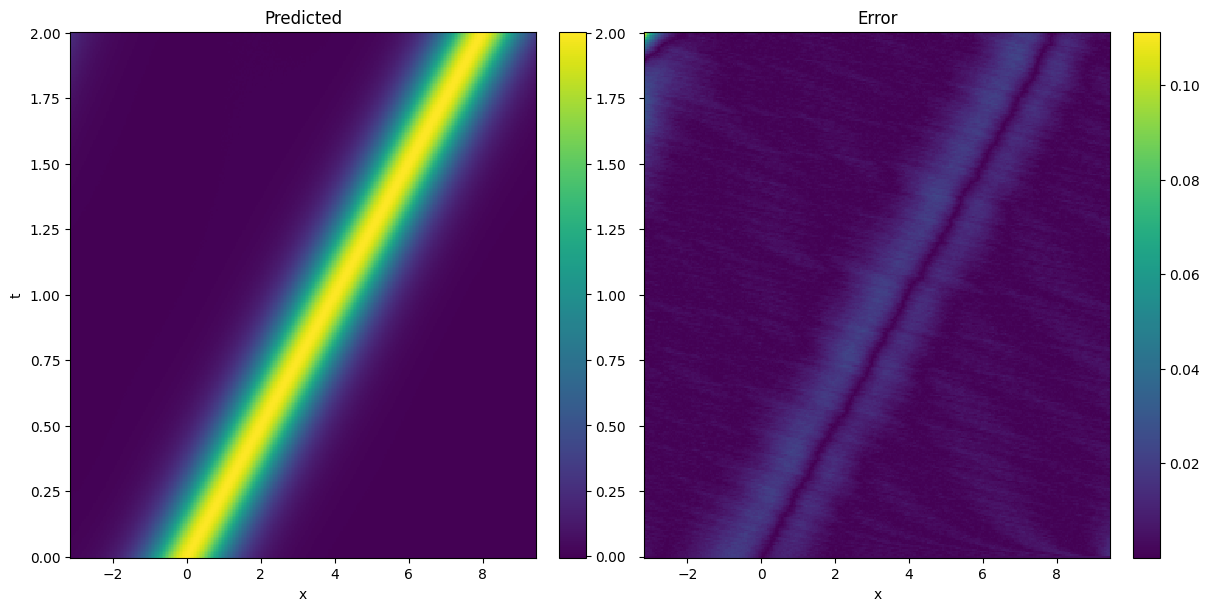

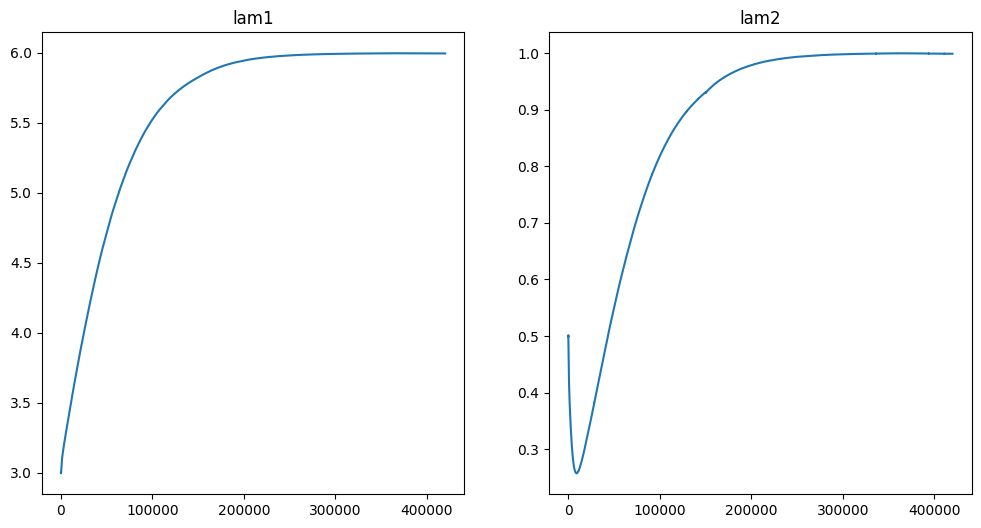

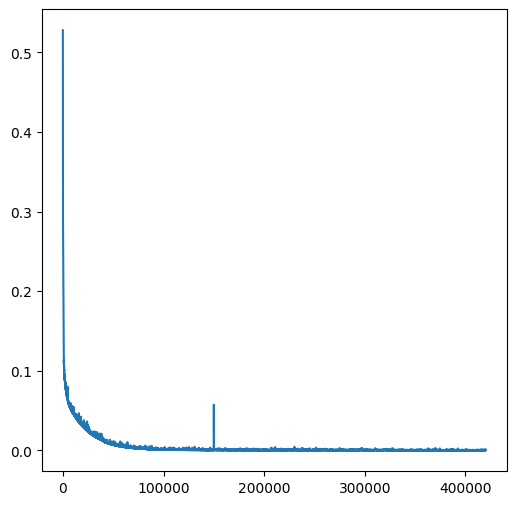

Step: 420250, Loss: 8.598584827268496e-05
Data loss: 1.8830332919606008e-05, Phi loss: 6.715551717206836e-05
Lam1: 5.9951, lam2: 0.9989
Step: 420500, Loss: 2.6877314667217433e-05
Data loss: 1.099649762181798e-05, Phi loss: 1.5880817954894155e-05
Lam1: 5.9951, lam2: 0.9989
Step: 420750, Loss: 1.8933786122943275e-05
Data loss: 9.797236998565495e-06, Phi loss: 9.13654912437778e-06
Lam1: 5.9951, lam2: 0.9989
Step: 421000, Loss: 7.433506107190624e-05
Data loss: 1.7360240235575475e-05, Phi loss: 5.697481901734136e-05
Lam1: 5.9951, lam2: 0.9989
Step: 421250, Loss: 1.5687373888795264e-05
Data loss: 8.797234841040336e-06, Phi loss: 6.890139502502279e-06
Lam1: 5.995, lam2: 0.9989
Step: 421500, Loss: 1.0950291652989108e-05
Data loss: 8.441598765784875e-06, Phi loss: 2.5086928872042336e-06
Lam1: 5.995, lam2: 0.9989
Step: 421750, Loss: 2.5973620722652413e-05
Data loss: 9.008967026602477e-06, Phi loss: 1.6964653696049936e-05
Lam1: 5.995, lam2: 0.9989
Step: 422000, Loss: 2.037123340414837e-05
Data lo

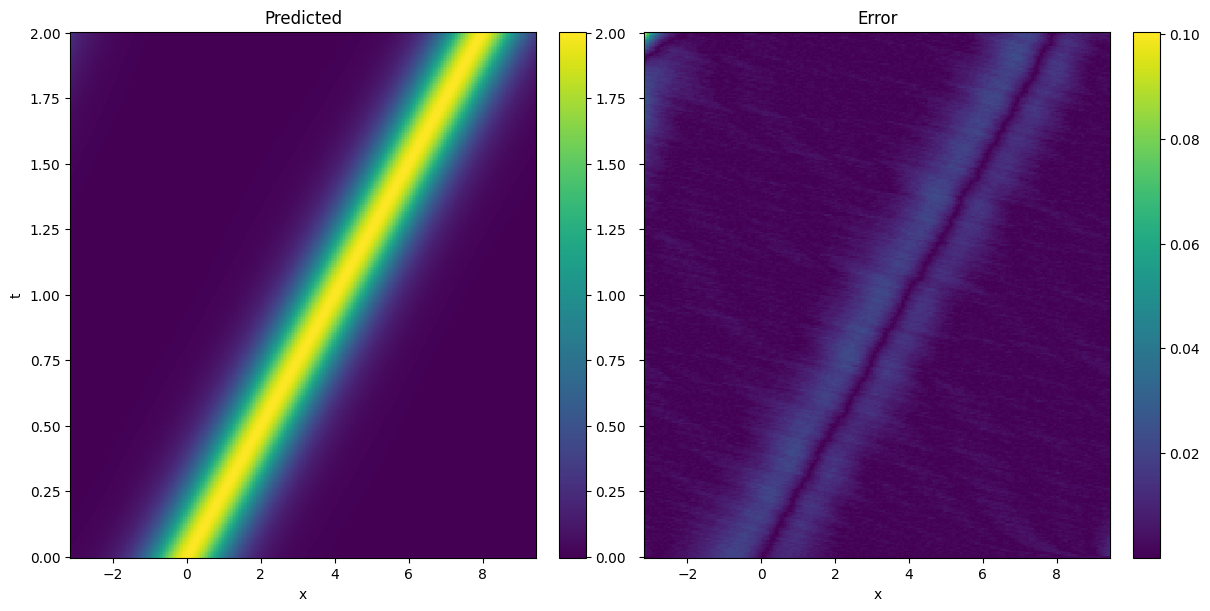

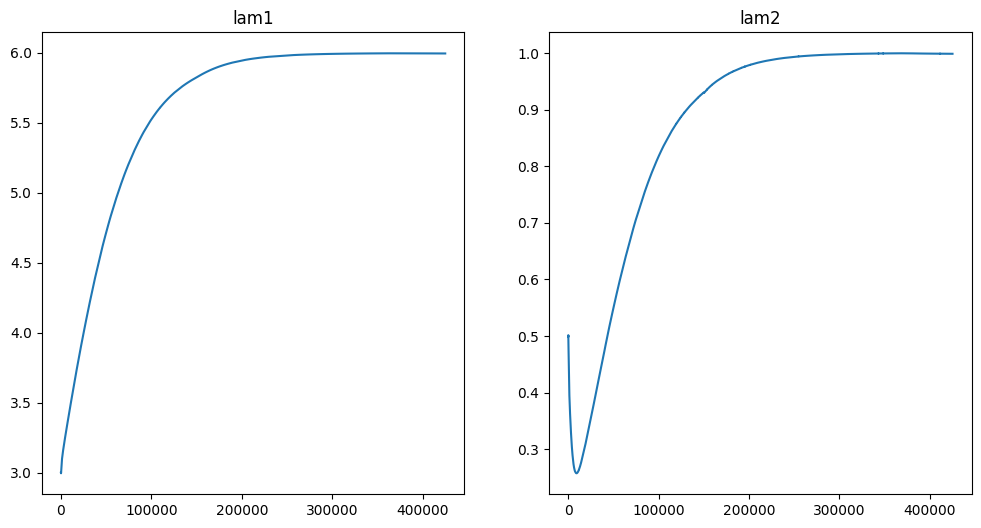

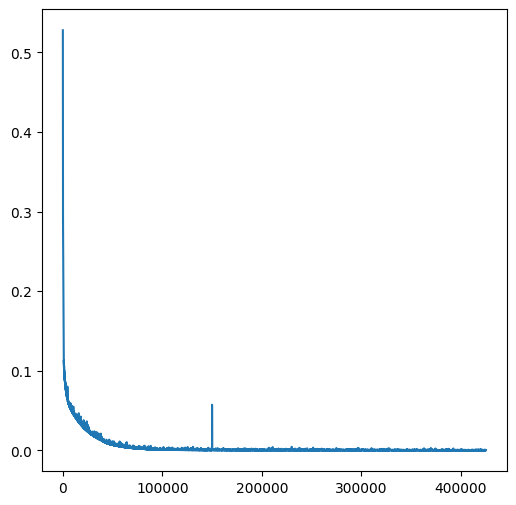

Step: 425250, Loss: 1.1561810424609575e-05
Data loss: 7.855632247810718e-06, Phi loss: 3.706178404172533e-06
Lam1: 5.9949, lam2: 0.9988
Step: 425500, Loss: 1.5303077816497535e-05
Data loss: 8.663789230922703e-06, Phi loss: 6.639288130827481e-06
Lam1: 5.9949, lam2: 0.9988
Step: 425750, Loss: 1.0068118172057439e-05
Data loss: 7.46815658203559e-06, Phi loss: 2.599961817395524e-06
Lam1: 5.9949, lam2: 0.9988
Step: 426000, Loss: 1.673320002737455e-05
Data loss: 8.478120435029268e-06, Phi loss: 8.25507868285058e-06
Lam1: 5.9949, lam2: 0.9988
Step: 426250, Loss: 1.2160033293184824e-05
Data loss: 7.662402822461445e-06, Phi loss: 4.497630470723379e-06
Lam1: 5.9949, lam2: 0.9988
Step: 426500, Loss: 1.1893005648744293e-05
Data loss: 7.653813554497901e-06, Phi loss: 4.23919163949904e-06
Lam1: 5.9949, lam2: 0.9988
Step: 426750, Loss: 1.3397593647823669e-05
Data loss: 7.645048754056916e-06, Phi loss: 5.752544893766753e-06
Lam1: 5.9949, lam2: 0.9988
Step: 427000, Loss: 1.020371746562887e-05
Data loss:

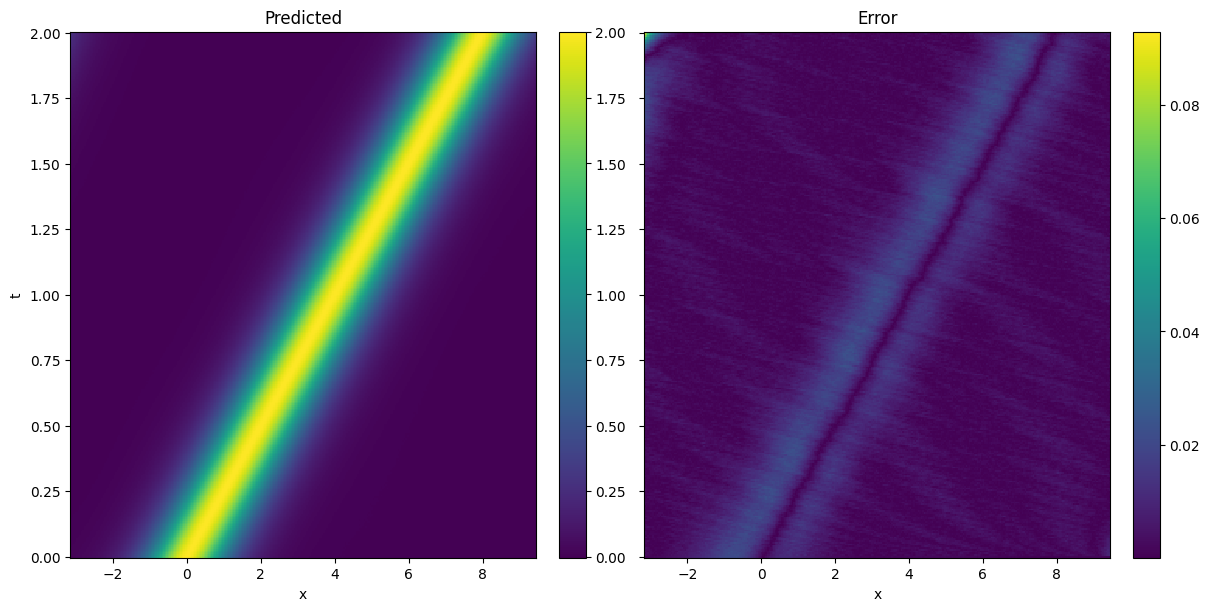

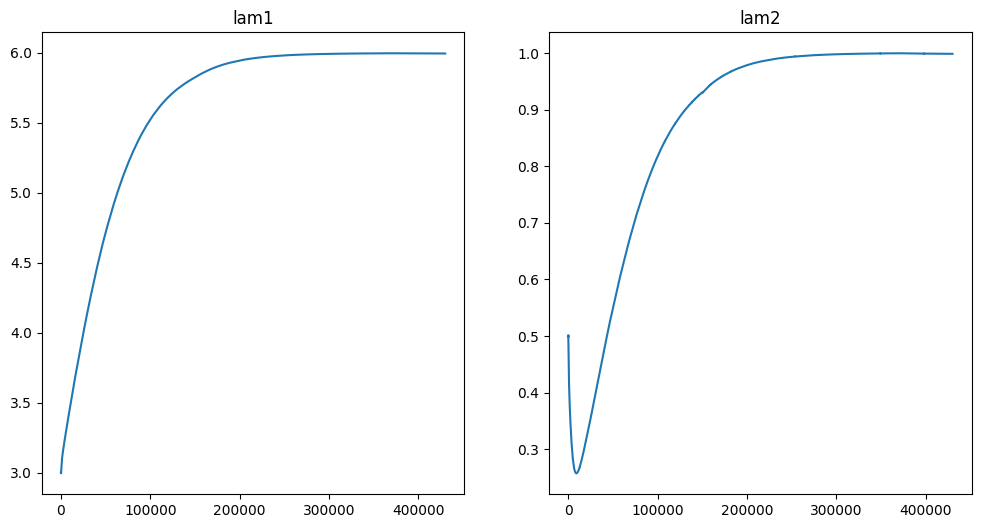

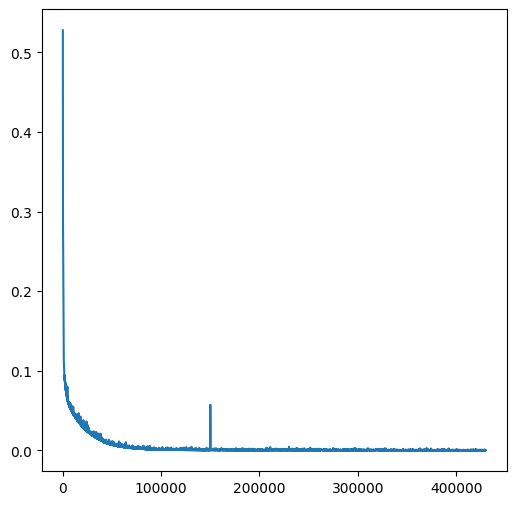

Step: 430250, Loss: 9.775476792128757e-05
Data loss: 2.17888464248972e-05, Phi loss: 7.596592331537977e-05
Lam1: 5.9948, lam2: 0.9988
Step: 430500, Loss: 1.0055337952508125e-05
Data loss: 6.969507012399845e-06, Phi loss: 3.085831167481956e-06
Lam1: 5.9948, lam2: 0.9988
Step: 430750, Loss: 1.0974144970532507e-05
Data loss: 6.879523425595835e-06, Phi loss: 4.094621999684023e-06
Lam1: 5.9948, lam2: 0.9988
Step: 431000, Loss: 8.89707553142216e-06
Data loss: 6.594827937078662e-06, Phi loss: 2.3022480490908492e-06
Lam1: 5.9948, lam2: 0.9988
Step: 431250, Loss: 8.929822797654197e-06
Data loss: 6.605007911275607e-06, Phi loss: 2.3248146590049146e-06
Lam1: 5.9948, lam2: 0.9988
Step: 431500, Loss: 1.7266262148041278e-05
Data loss: 8.275614163721912e-06, Phi loss: 8.990647074824665e-06
Lam1: 5.9948, lam2: 0.9988
Step: 431750, Loss: 2.015193604165688e-05
Data loss: 6.775530437153066e-06, Phi loss: 1.3376405149756465e-05
Lam1: 5.9948, lam2: 0.9988
Step: 432000, Loss: 2.0394309103721753e-05
Data los

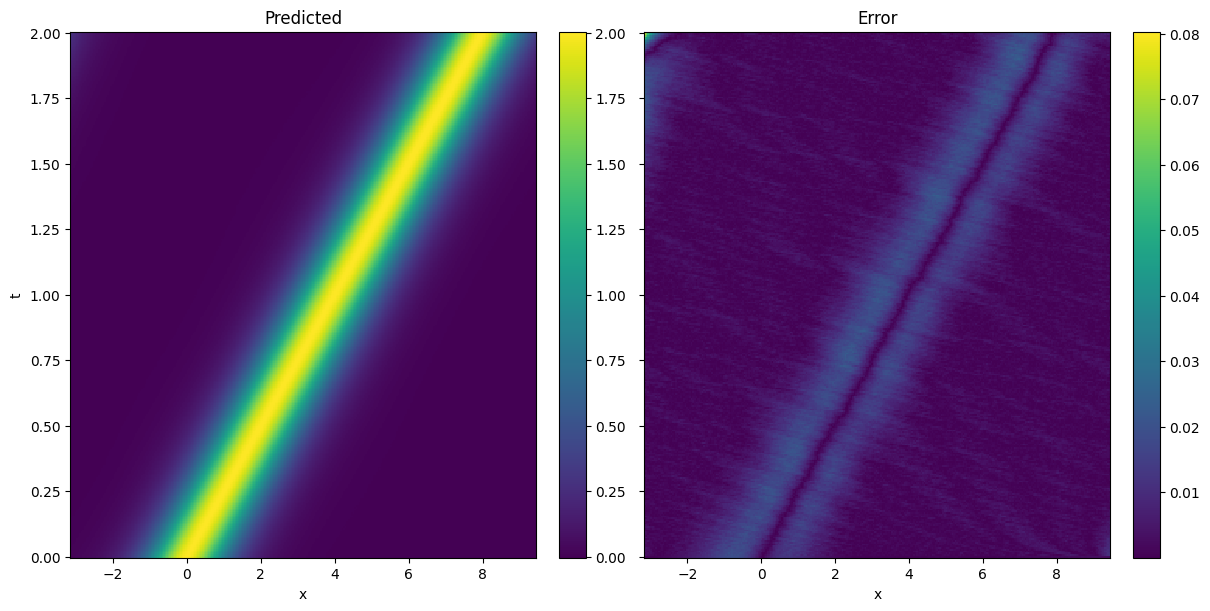

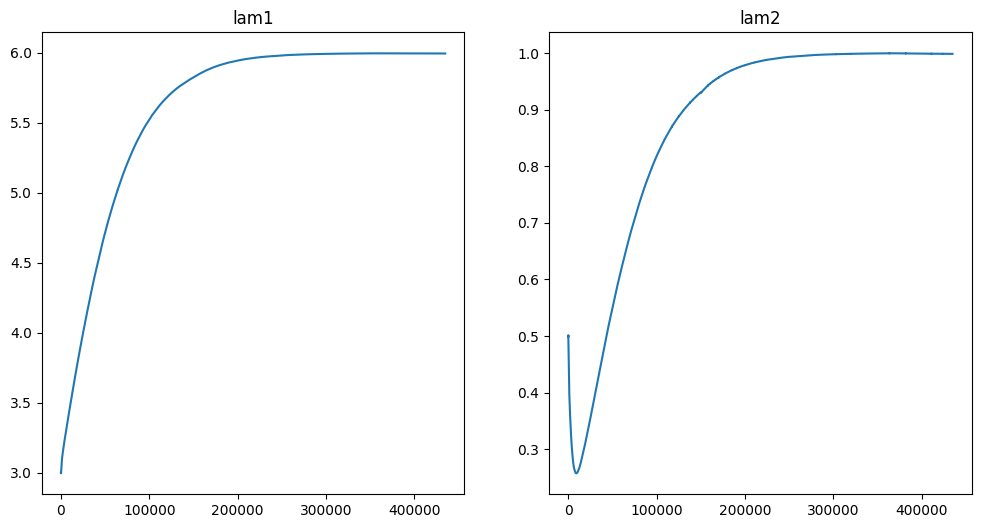

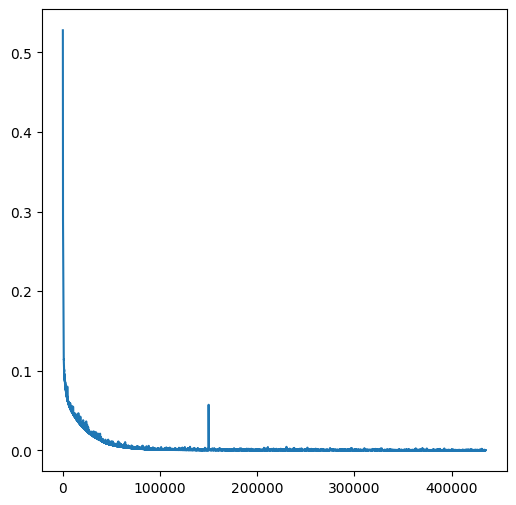

Step: 435250, Loss: 1.4068537893763278e-05
Data loss: 6.5398980950703844e-06, Phi loss: 7.528639798692893e-06
Lam1: 5.9947, lam2: 0.9987
Step: 435500, Loss: 5.879763193661347e-05
Data loss: 1.1475796782178804e-05, Phi loss: 4.7321835154434666e-05
Lam1: 5.9947, lam2: 0.9987
Step: 435750, Loss: 1.9153059838572517e-05
Data loss: 6.990781002969015e-06, Phi loss: 1.21622779261088e-05
Lam1: 5.9947, lam2: 0.9987
Step: 436000, Loss: 0.00013193048653192818
Data loss: 2.2320993593893945e-05, Phi loss: 0.00010960948566207662
Lam1: 5.9947, lam2: 0.9987
Step: 436250, Loss: 1.2647476978600025e-05
Data loss: 6.410238256648881e-06, Phi loss: 6.237238721951144e-06
Lam1: 5.9947, lam2: 0.9987
Step: 436500, Loss: 9.152292477665469e-06
Data loss: 5.981941740174079e-06, Phi loss: 3.1703505101177143e-06
Lam1: 5.9947, lam2: 0.9987
Step: 436750, Loss: 1.293365585297579e-05
Data loss: 5.893686648050789e-06, Phi loss: 7.039969204925001e-06
Lam1: 5.9947, lam2: 0.9987
Step: 437000, Loss: 2.5503575670882128e-05
Dat

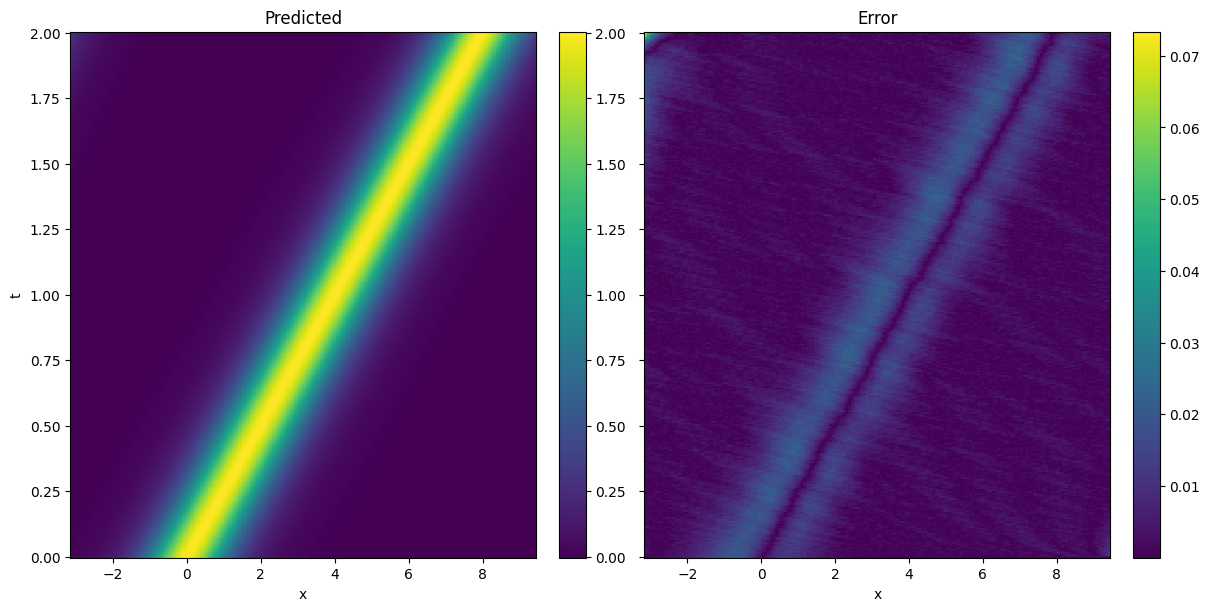

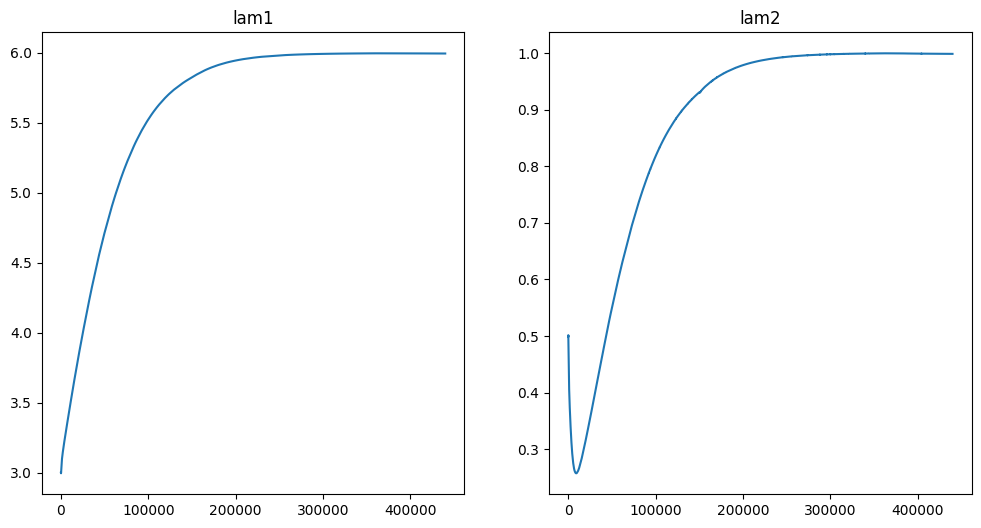

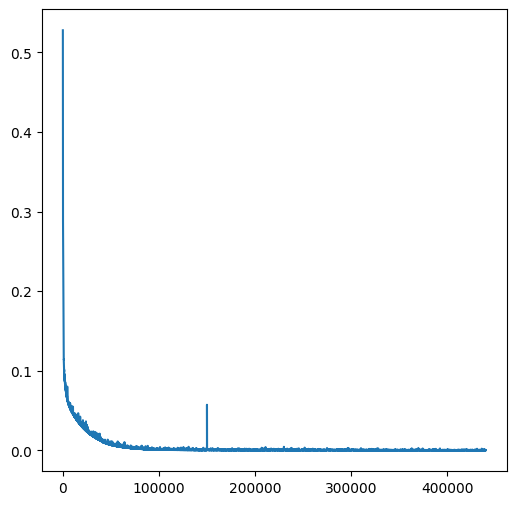

Step: 440250, Loss: 1.586934013175778e-05
Data loss: 6.39961854176363e-06, Phi loss: 9.46972068049945e-06
Lam1: 5.9946, lam2: 0.9987
Step: 440500, Loss: 2.430065615044441e-05
Data loss: 6.055555331840878e-06, Phi loss: 1.824510036385618e-05
Lam1: 5.9946, lam2: 0.9987
Step: 440750, Loss: 1.3914407645643223e-05
Data loss: 6.298679636529414e-06, Phi loss: 7.615728009113809e-06
Lam1: 5.9946, lam2: 0.9987
Step: 441000, Loss: 7.4785239121410996e-06
Data loss: 5.363348464015871e-06, Phi loss: 2.1151754481252283e-06
Lam1: 5.9946, lam2: 0.9987
Step: 441250, Loss: 1.1649861335172318e-05
Data loss: 5.686314125341596e-06, Phi loss: 5.963546755083371e-06
Lam1: 5.9946, lam2: 0.9987
Step: 441500, Loss: 9.246101399185136e-06
Data loss: 5.440210316010052e-06, Phi loss: 3.8058910831750836e-06
Lam1: 5.9946, lam2: 0.9987
Step: 441750, Loss: 9.603209036868066e-06
Data loss: 5.458366103994194e-06, Phi loss: 4.14484247812652e-06
Lam1: 5.9946, lam2: 0.9987
Step: 442000, Loss: 2.005664646276273e-05
Data loss: 

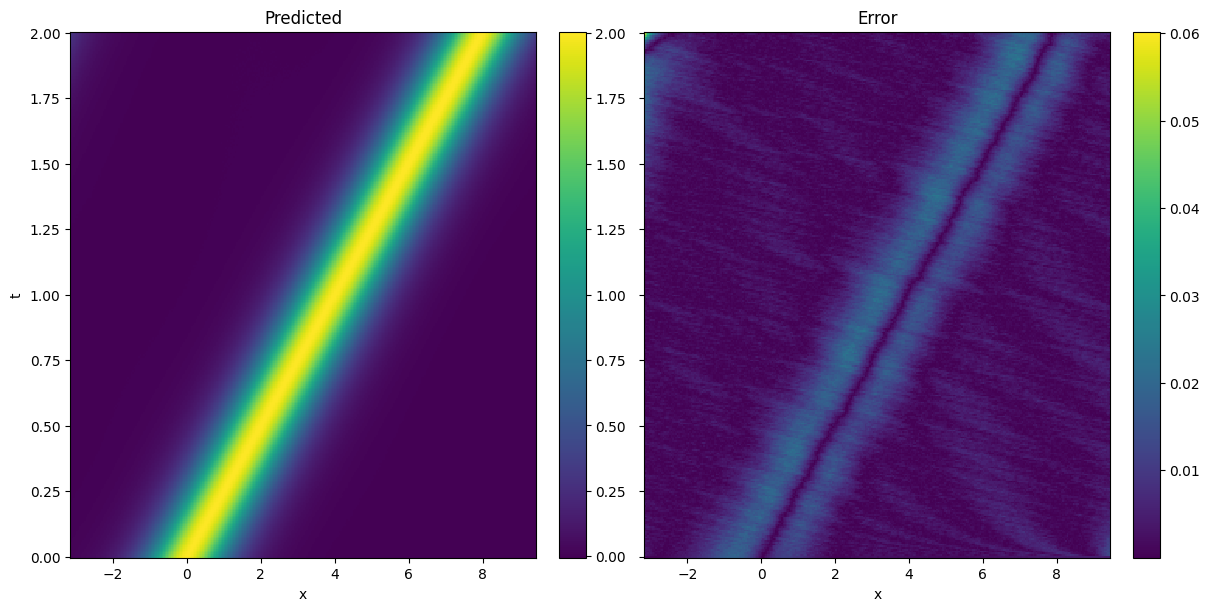

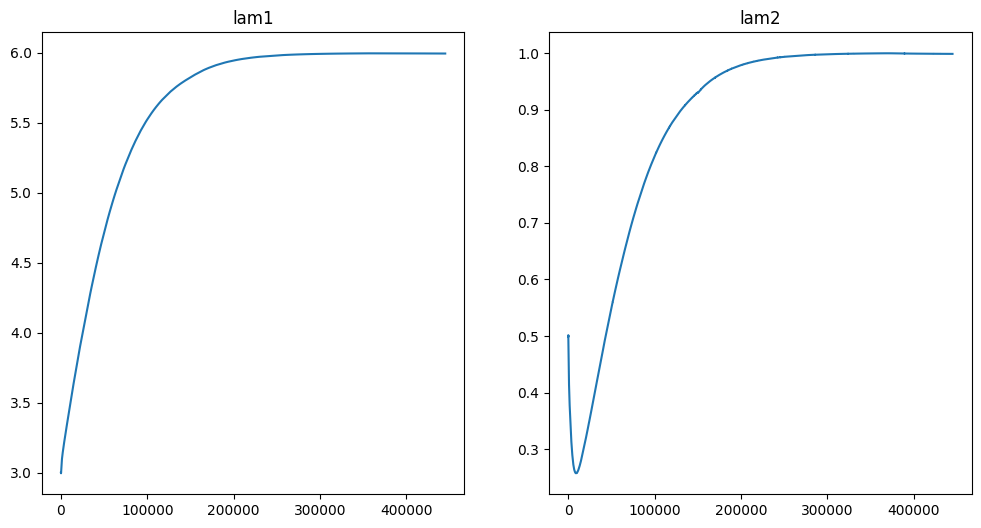

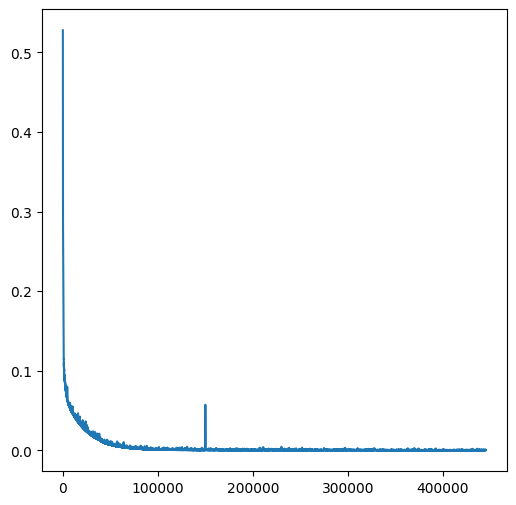

Step: 445250, Loss: 9.701399903860874e-06
Data loss: 5.032472927268827e-06, Phi loss: 4.668927431339398e-06
Lam1: 5.9945, lam2: 0.9987
Step: 445500, Loss: 1.8057302440865897e-05
Data loss: 5.312622761266539e-06, Phi loss: 1.2744679224852007e-05
Lam1: 5.9945, lam2: 0.9987
Step: 445750, Loss: 1.0233286957372911e-05
Data loss: 5.007890649721958e-06, Phi loss: 5.225395852903603e-06
Lam1: 5.9945, lam2: 0.9987
Step: 446000, Loss: 2.439503077766858e-05
Data loss: 5.4965244089544285e-06, Phi loss: 1.8898506823461503e-05
Lam1: 5.9945, lam2: 0.9987
Step: 446250, Loss: 2.5669894966995344e-05
Data loss: 5.677231456502341e-06, Phi loss: 1.9992663510493003e-05
Lam1: 5.9945, lam2: 0.9987
Step: 446500, Loss: 1.8324953998671845e-05
Data loss: 5.106759999762289e-06, Phi loss: 1.3218193998909555e-05
Lam1: 5.9945, lam2: 0.9986
Step: 446750, Loss: 1.4043365808902308e-05
Data loss: 5.727470579586225e-06, Phi loss: 8.315894774568733e-06
Lam1: 5.9945, lam2: 0.9986
Step: 447000, Loss: 6.808228135923855e-06
Dat

In [29]:
%%time
for i in range(2):
    kdv.train(25000)
    kdv.save()

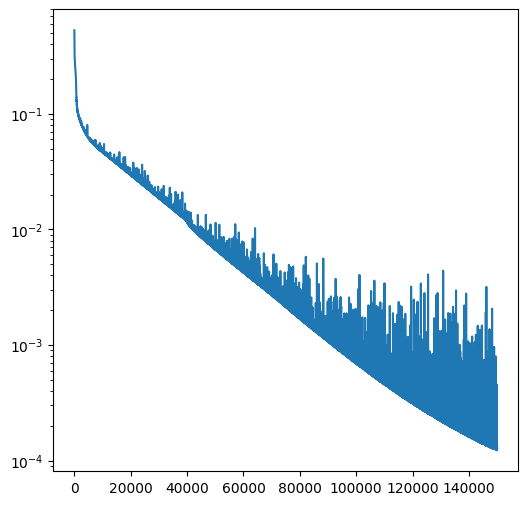

In [17]:
plt.semilogy(kdv.loss[:150000])

%%%%%%%%%%%%%%%
2
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.3271867334842682
Data loss: 0.3267945349216461, Phi loss: 0.000392193382140249
Lam1: 3.0, lam2: 0.5


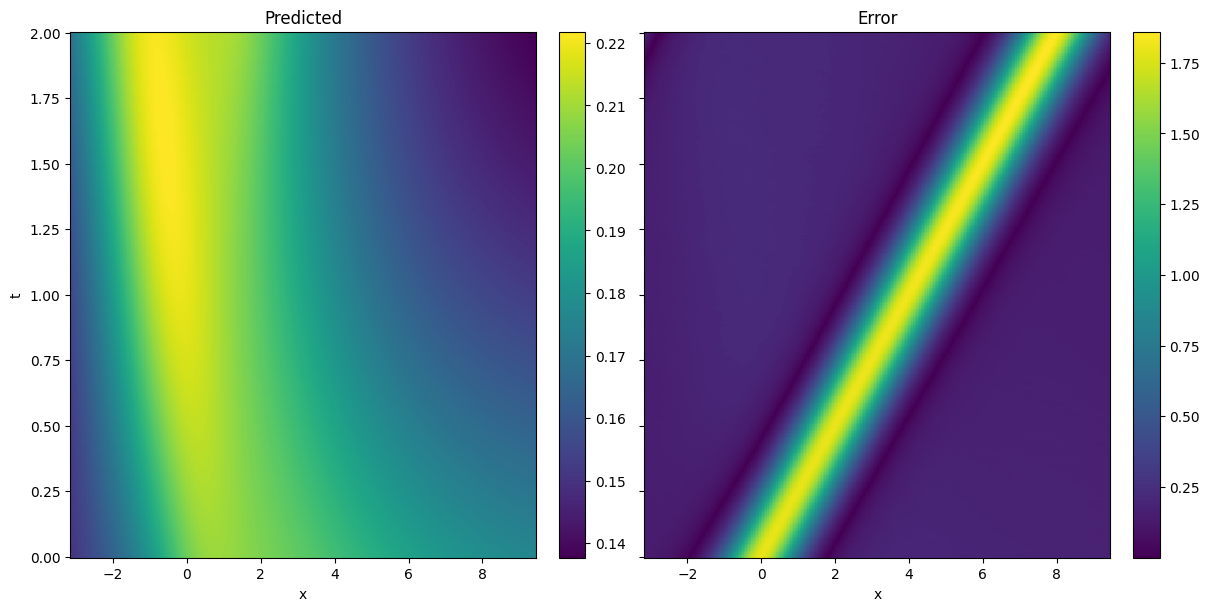

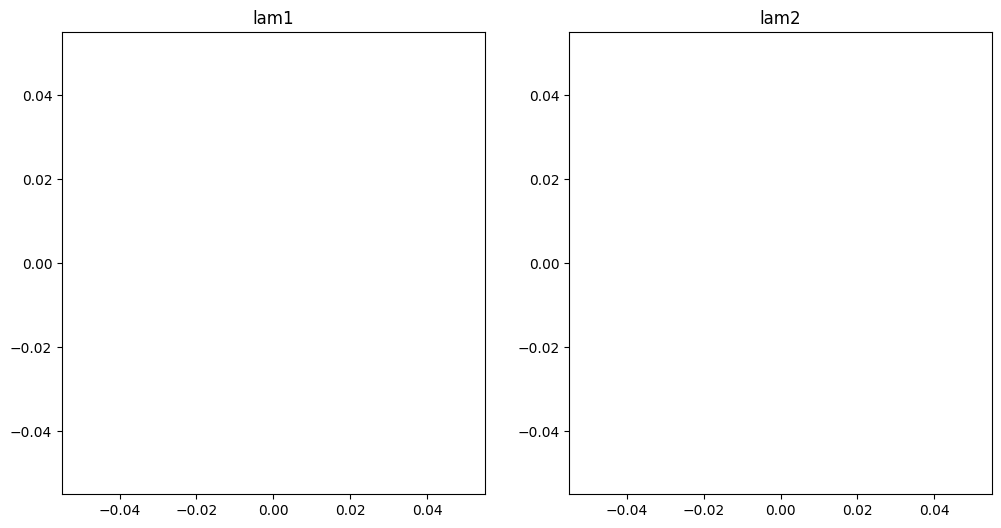

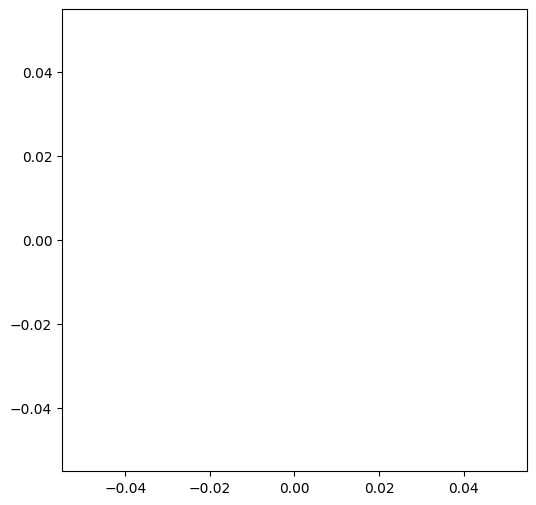

Step: 250, Loss: 0.29619598388671875
Data loss: 0.2952853739261627, Phi loss: 0.0009106096695177257
Lam1: 2.9967, lam2: 0.5031
Step: 500, Loss: 0.2876151502132416
Data loss: 0.28676170110702515, Phi loss: 0.0008534551016055048
Lam1: 2.9932, lam2: 0.5063
Step: 750, Loss: 0.28375083208084106
Data loss: 0.28320029377937317, Phi loss: 0.0005505465669557452
Lam1: 2.9906, lam2: 0.5086
Step: 1000, Loss: 0.2809532880783081
Data loss: 0.2804704010486603, Phi loss: 0.000482884090160951
Lam1: 2.9891, lam2: 0.5097
Step: 1250, Loss: 0.2786045968532562
Data loss: 0.2779945433139801, Phi loss: 0.0006100540631450713
Lam1: 2.9891, lam2: 0.509
Step: 1500, Loss: 0.2764640748500824
Data loss: 0.2756342589855194, Phi loss: 0.0008298148750327528
Lam1: 2.9908, lam2: 0.5063
Step: 1750, Loss: 0.2743854224681854
Data loss: 0.27331262826919556, Phi loss: 0.0010727831395342946
Lam1: 2.994, lam2: 0.5023
Step: 2000, Loss: 0.2722615897655487
Data loss: 0.2709546387195587, Phi loss: 0.0013069389387965202
Lam1: 2.9979

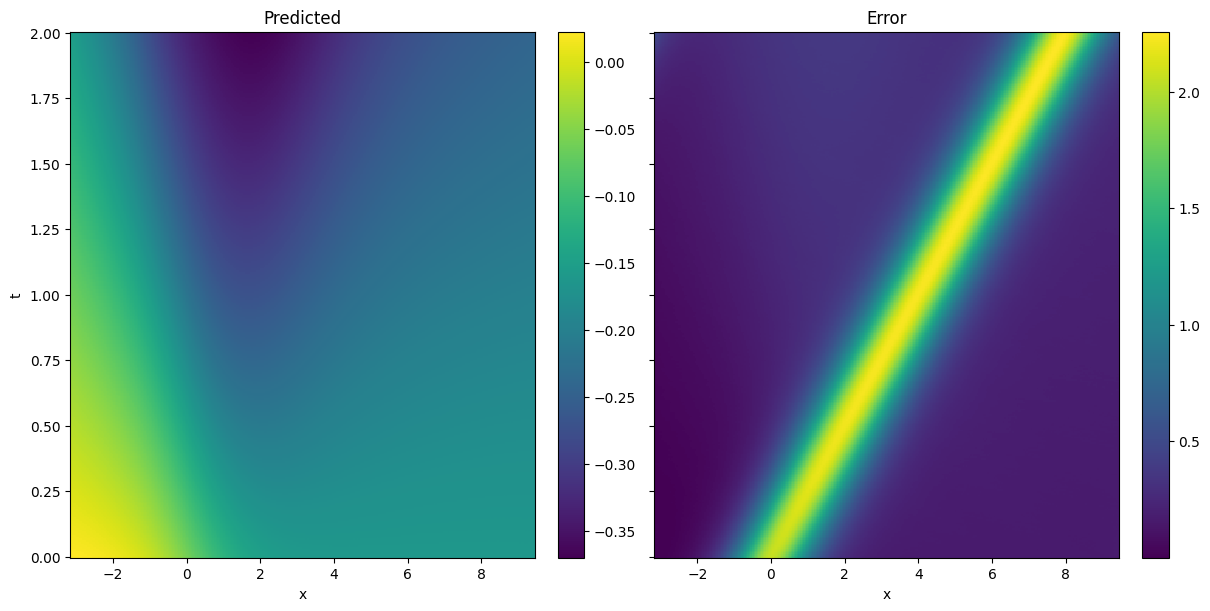

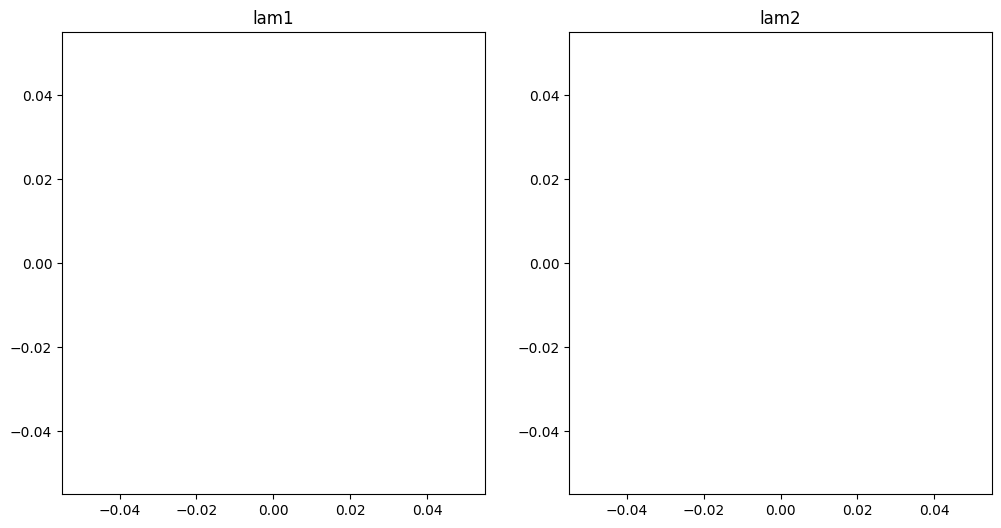

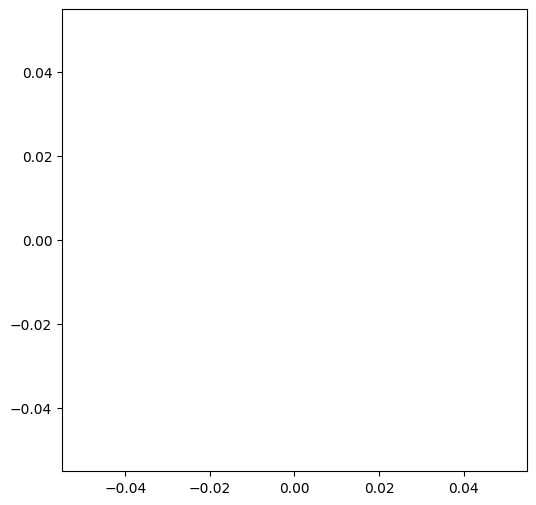

Step: 250, Loss: 0.3552863299846649
Data loss: 0.3510272800922394, Phi loss: 0.004259063862264156
Lam1: 2.9982, lam2: 0.4974
Step: 500, Loss: 0.29568031430244446
Data loss: 0.29471465945243835, Phi loss: 0.0009656432666815817
Lam1: 2.9985, lam2: 0.4946
Step: 750, Loss: 0.2807248532772064
Data loss: 0.2800333797931671, Phi loss: 0.0006914597470313311
Lam1: 3.0, lam2: 0.4934
Step: 1000, Loss: 0.2735874354839325
Data loss: 0.27275145053863525, Phi loss: 0.000835996528621763
Lam1: 3.0016, lam2: 0.4935
Step: 1250, Loss: 0.2675124704837799
Data loss: 0.2664635479450226, Phi loss: 0.0010489362757652998
Lam1: 3.0059, lam2: 0.4932
Step: 1500, Loss: 0.2614048719406128
Data loss: 0.25998228788375854, Phi loss: 0.0014225796330720186
Lam1: 3.0112, lam2: 0.4912
Step: 1750, Loss: 0.25510096549987793
Data loss: 0.2530852258205414, Phi loss: 0.0020157292019575834
Lam1: 3.0164, lam2: 0.4871
Step: 2000, Loss: 0.24874834716320038
Data loss: 0.24583354592323303, Phi loss: 0.002914803335443139
Lam1: 3.0213,

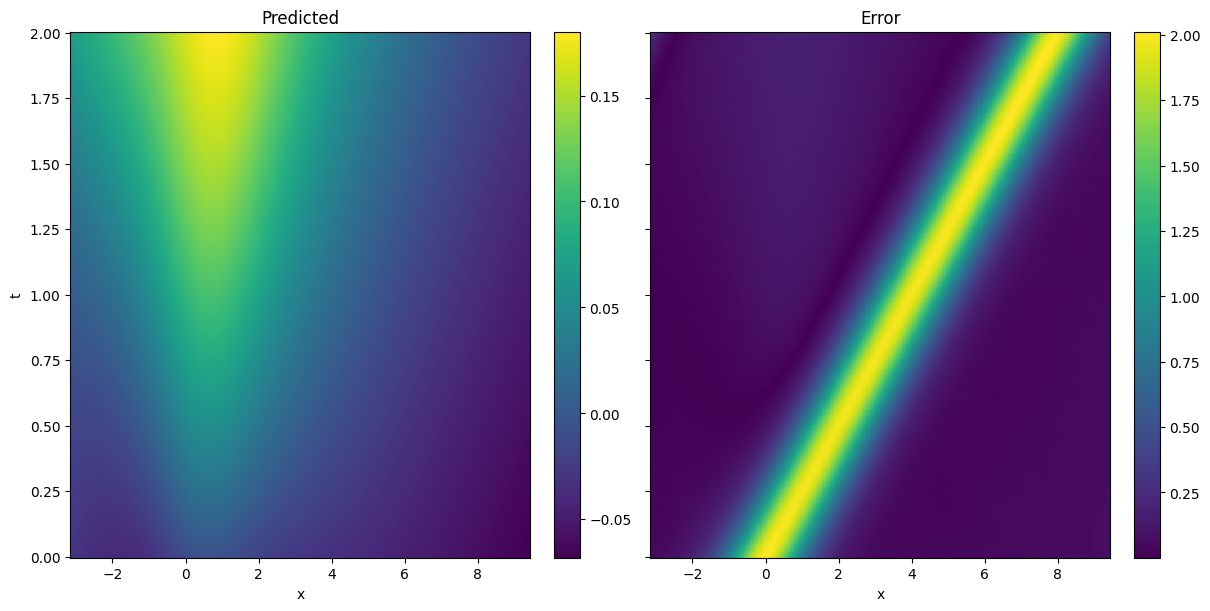

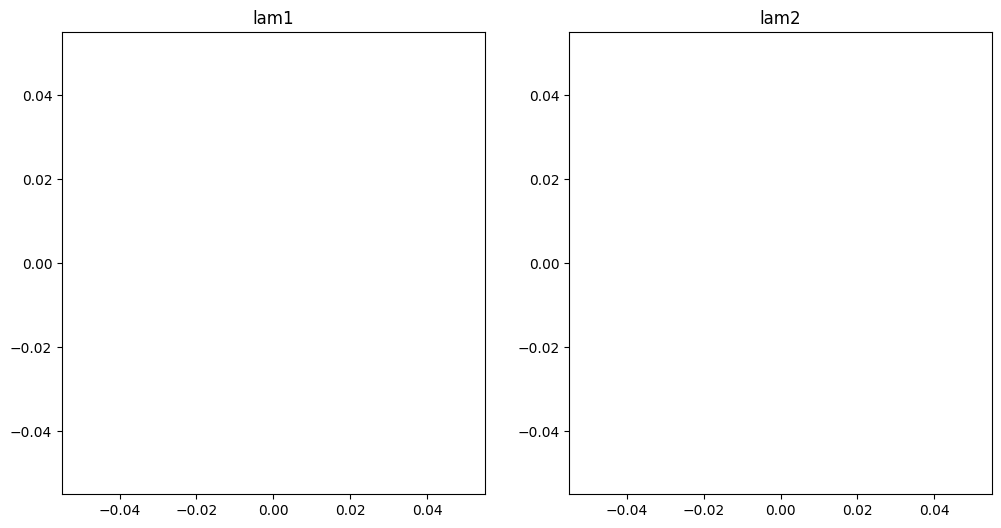

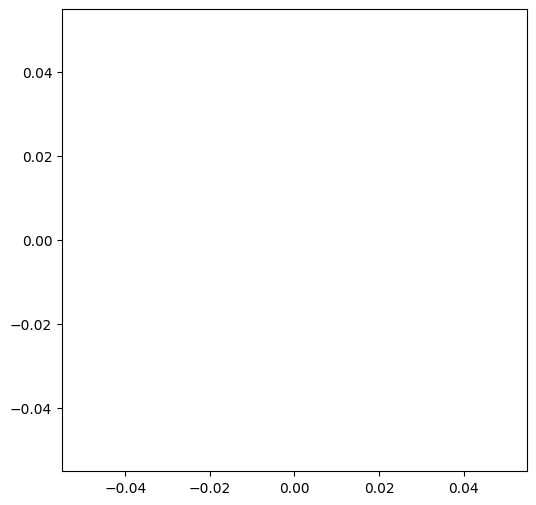

Step: 250, Loss: 0.2779060900211334
Data loss: 0.27651247382164, Phi loss: 0.0013936235336586833
Lam1: 2.9967, lam2: 0.4995
Step: 500, Loss: 0.25708481669425964
Data loss: 0.25586241483688354, Phi loss: 0.0012223913799971342
Lam1: 2.9963, lam2: 0.4971
Step: 750, Loss: 0.24482810497283936
Data loss: 0.24131537973880768, Phi loss: 0.0035127191804349422
Lam1: 3.0001, lam2: 0.4927
Step: 1000, Loss: 0.23466676473617554
Data loss: 0.22863389551639557, Phi loss: 0.006032868288457394
Lam1: 3.0047, lam2: 0.488
Step: 1250, Loss: 0.22659751772880554
Data loss: 0.21781952679157257, Phi loss: 0.008777989074587822
Lam1: 3.0092, lam2: 0.4834
Step: 1500, Loss: 0.22067366540431976
Data loss: 0.20938827097415924, Phi loss: 0.011285395361483097
Lam1: 3.0134, lam2: 0.4792
Step: 1750, Loss: 0.2162017971277237
Data loss: 0.20307186245918274, Phi loss: 0.013129941187798977
Lam1: 3.0174, lam2: 0.4753
Step: 2000, Loss: 0.212306410074234
Data loss: 0.19808585941791534, Phi loss: 0.014220543205738068
Lam1: 3.021

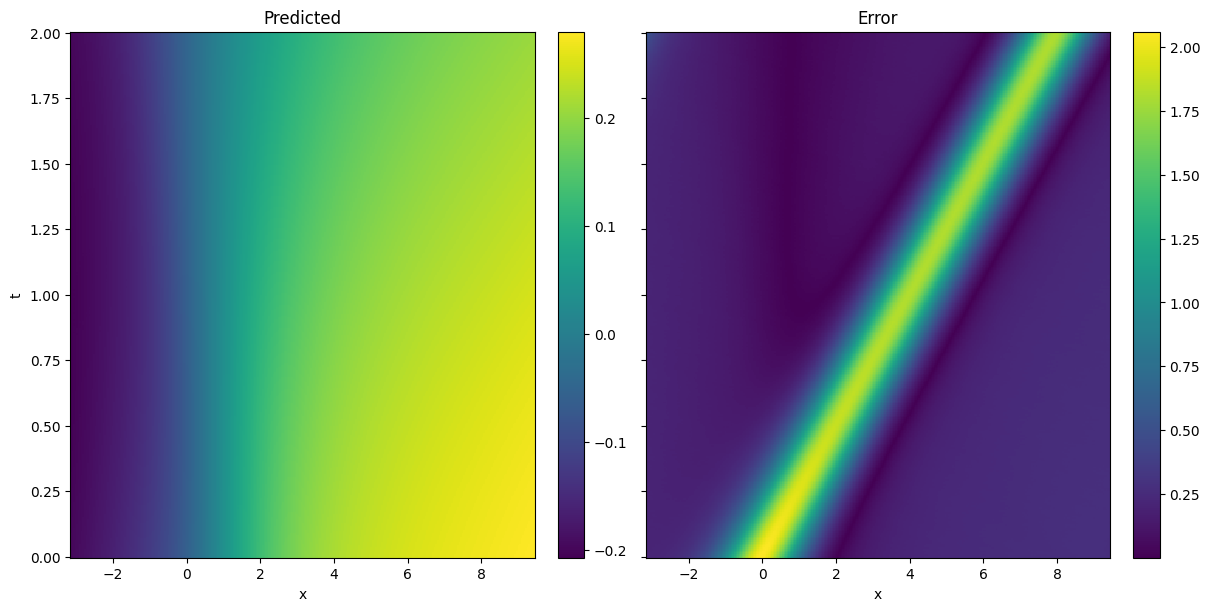

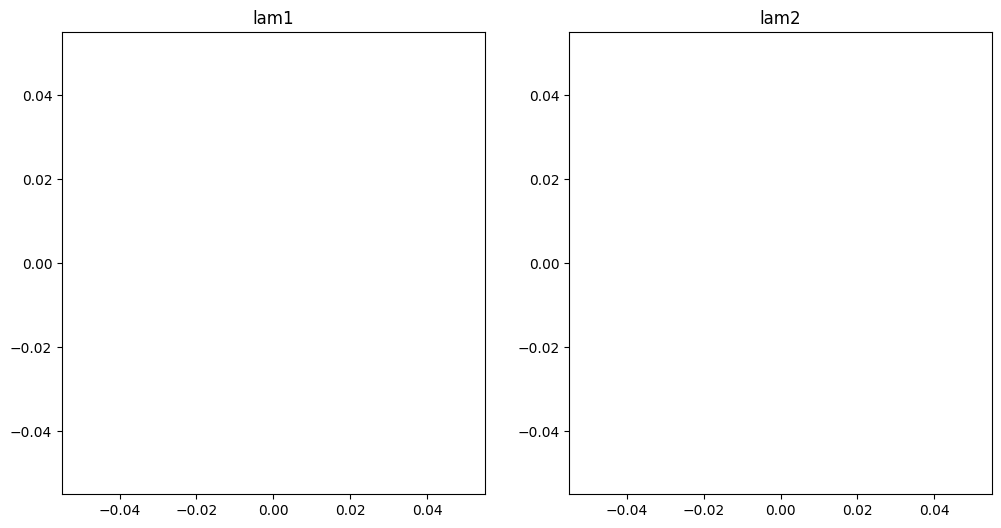

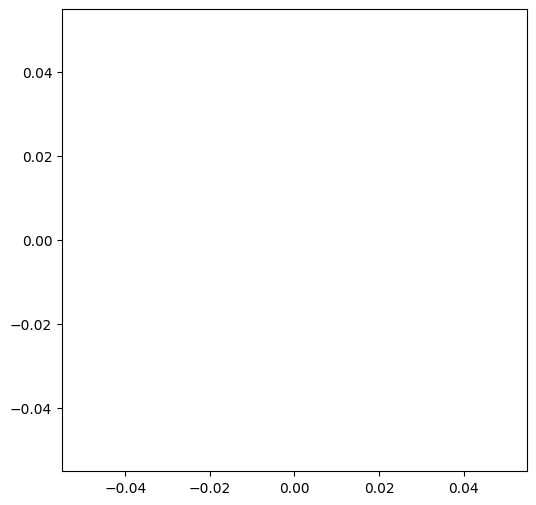

Step: 250, Loss: 0.24683663249015808
Data loss: 0.24314452707767487, Phi loss: 0.0036921012215316296
Lam1: 3.0011, lam2: 0.4975
Step: 500, Loss: 0.2267387956380844
Data loss: 0.2146500200033188, Phi loss: 0.012088773772120476
Lam1: 3.0057, lam2: 0.4932
Step: 750, Loss: 0.21943914890289307
Data loss: 0.20493368804454803, Phi loss: 0.014505458064377308
Lam1: 3.0096, lam2: 0.49
Step: 1000, Loss: 0.21478652954101562
Data loss: 0.1998925805091858, Phi loss: 0.014893944375216961
Lam1: 3.0133, lam2: 0.4867
Step: 1250, Loss: 0.21031975746154785
Data loss: 0.19518417119979858, Phi loss: 0.01513558067381382
Lam1: 3.0167, lam2: 0.4833
Step: 1500, Loss: 0.2057599425315857
Data loss: 0.19000397622585297, Phi loss: 0.015755970031023026
Lam1: 3.0201, lam2: 0.4797
Step: 1750, Loss: 0.2008504420518875
Data loss: 0.18444779515266418, Phi loss: 0.016402652487158775
Lam1: 3.0235, lam2: 0.476
Step: 2000, Loss: 0.1951342672109604
Data loss: 0.17732442915439606, Phi loss: 0.01780984364449978
Lam1: 3.027, lam

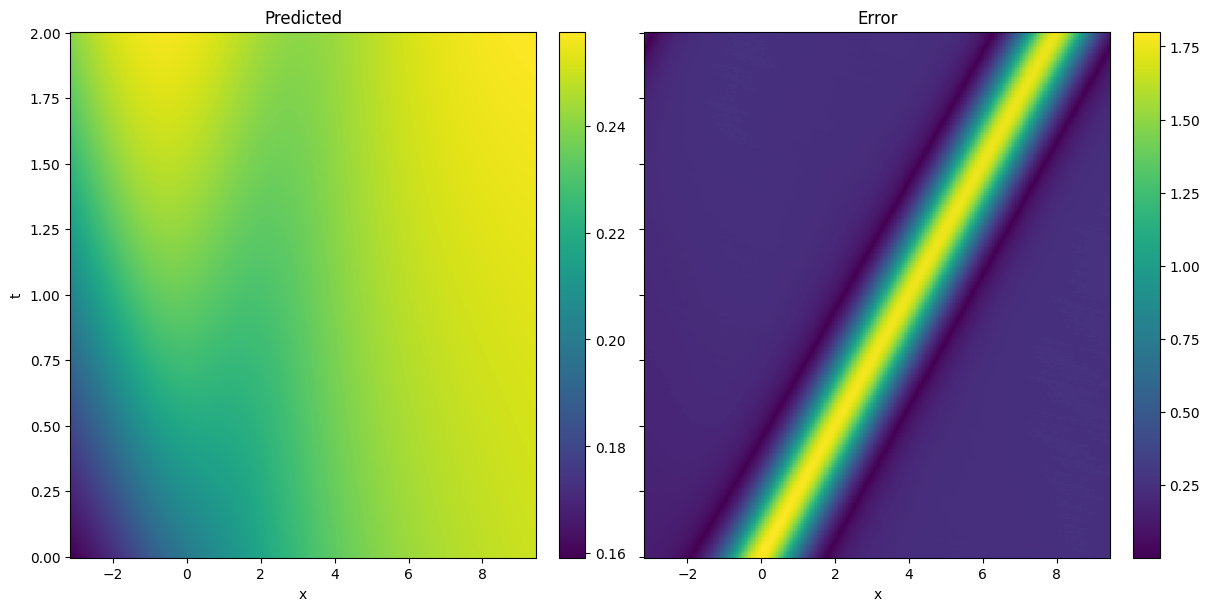

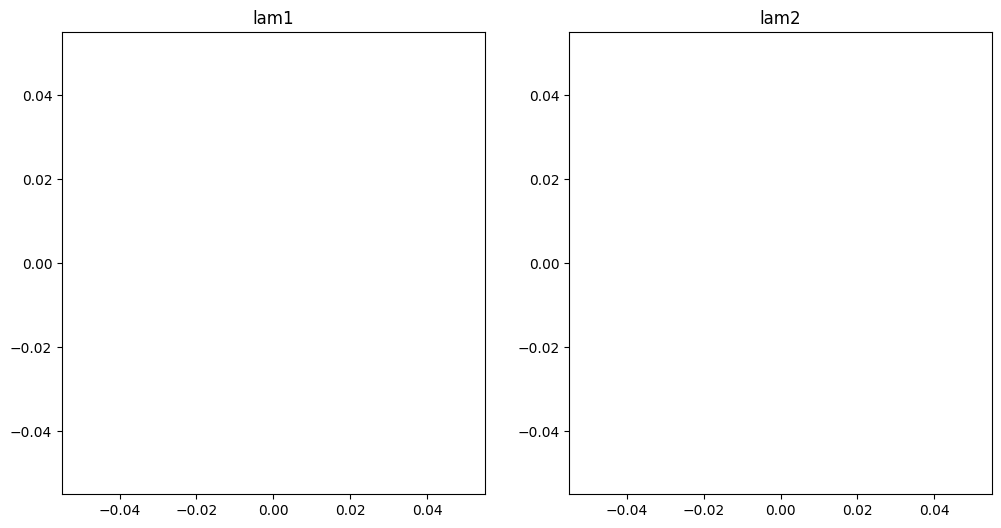

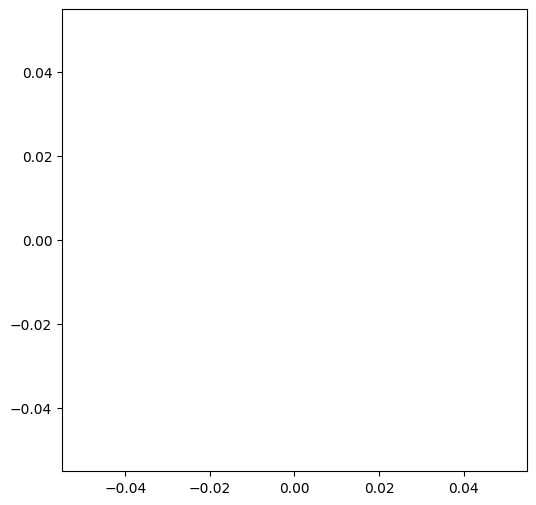

Step: 250, Loss: 0.29944244027137756
Data loss: 0.29842862486839294, Phi loss: 0.0010138232028111815
Lam1: 2.9968, lam2: 0.5029
Step: 500, Loss: 0.29167747497558594
Data loss: 0.29096725583076477, Phi loss: 0.000710232590790838
Lam1: 2.9935, lam2: 0.5058
Step: 750, Loss: 0.28694629669189453
Data loss: 0.2866468131542206, Phi loss: 0.00029947463190183043
Lam1: 2.9909, lam2: 0.5078
Step: 1000, Loss: 0.28335416316986084
Data loss: 0.2832767069339752, Phi loss: 7.74454019847326e-05
Lam1: 2.9893, lam2: 0.5083
Step: 1250, Loss: 0.2797098159790039
Data loss: 0.2796378433704376, Phi loss: 7.196156366262585e-05
Lam1: 2.9888, lam2: 0.5061
Step: 1500, Loss: 0.2752123475074768
Data loss: 0.27491137385368347, Phi loss: 0.0003009707434102893
Lam1: 2.9903, lam2: 0.5017
Step: 1750, Loss: 0.2691880762577057
Data loss: 0.26832616329193115, Phi loss: 0.0008619253640063107
Lam1: 2.9941, lam2: 0.4966
Step: 2000, Loss: 0.26138100028038025
Data loss: 0.2594870924949646, Phi loss: 0.0018939092988148332
Lam1: 

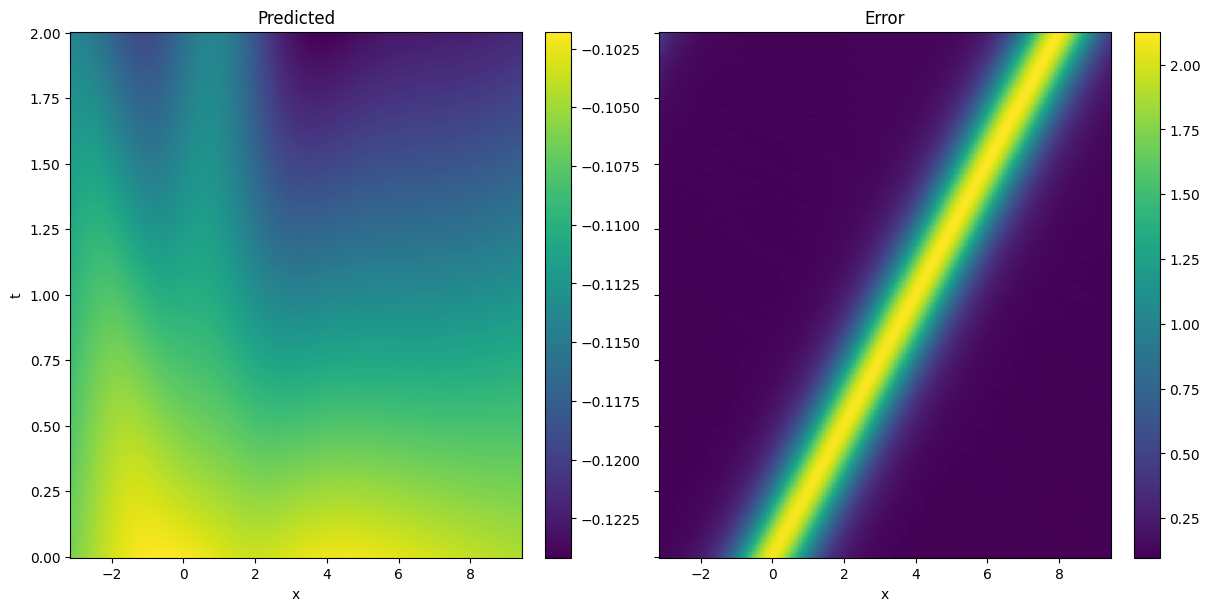

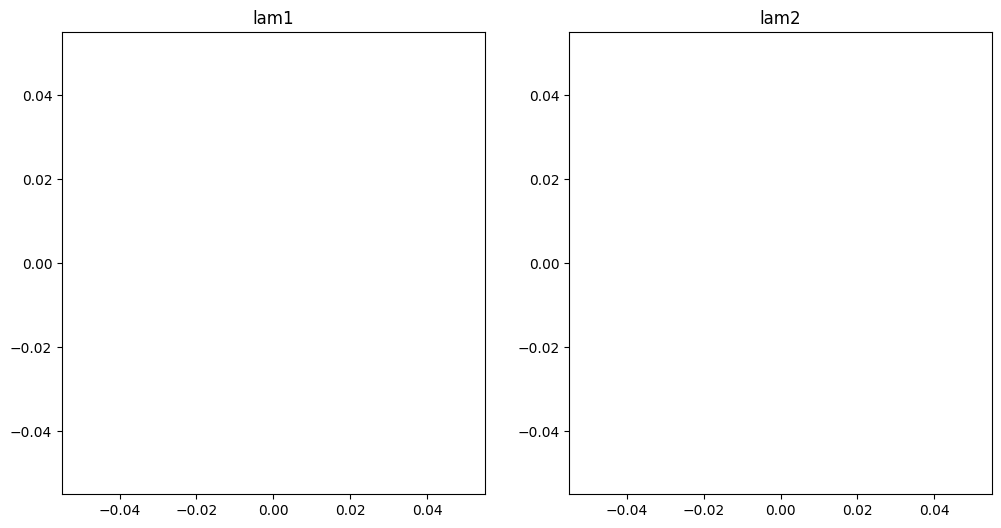

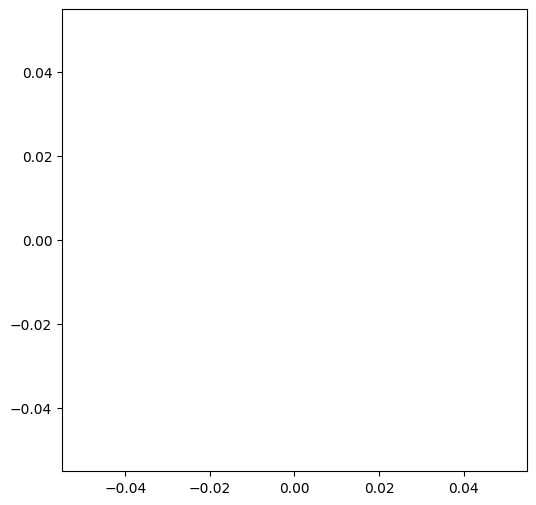

Step: 250, Loss: 0.3333705961704254
Data loss: 0.3332119286060333, Phi loss: 0.00015865280875004828
Lam1: 3.0, lam2: 0.4965
Step: 500, Loss: 0.2880612313747406
Data loss: 0.2870558798313141, Phi loss: 0.0010053508449345827
Lam1: 2.9935, lam2: 0.4984
Step: 750, Loss: 0.27596431970596313
Data loss: 0.27548372745513916, Phi loss: 0.0004806026117876172
Lam1: 2.9893, lam2: 0.5025
Step: 1000, Loss: 0.2660544216632843
Data loss: 0.2657298743724823, Phi loss: 0.00032455194741487503
Lam1: 2.9879, lam2: 0.502
Step: 1250, Loss: 0.25562959909439087
Data loss: 0.25419679284095764, Phi loss: 0.001432798570021987
Lam1: 2.9907, lam2: 0.497
Step: 1500, Loss: 0.24481183290481567
Data loss: 0.24109481275081635, Phi loss: 0.0037170271389186382
Lam1: 2.9962, lam2: 0.4915
Step: 1750, Loss: 0.23558729887008667
Data loss: 0.2287047952413559, Phi loss: 0.006882497109472752
Lam1: 3.0015, lam2: 0.4864
Step: 2000, Loss: 0.22932235896587372
Data loss: 0.2193029224872589, Phi loss: 0.01001943089067936
Lam1: 3.0064,

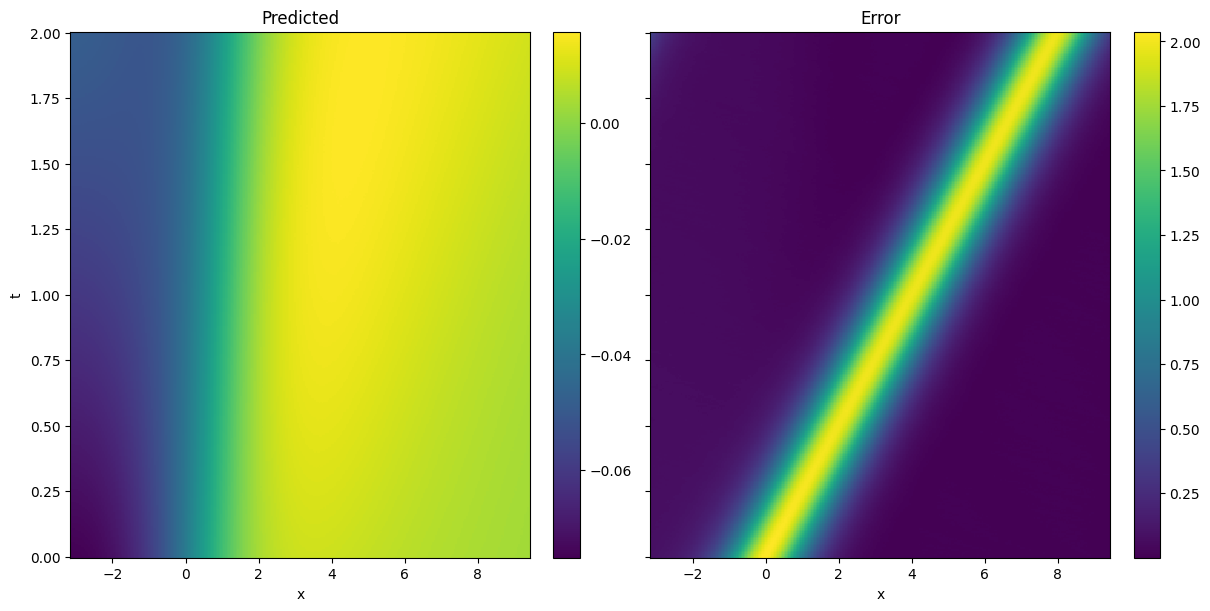

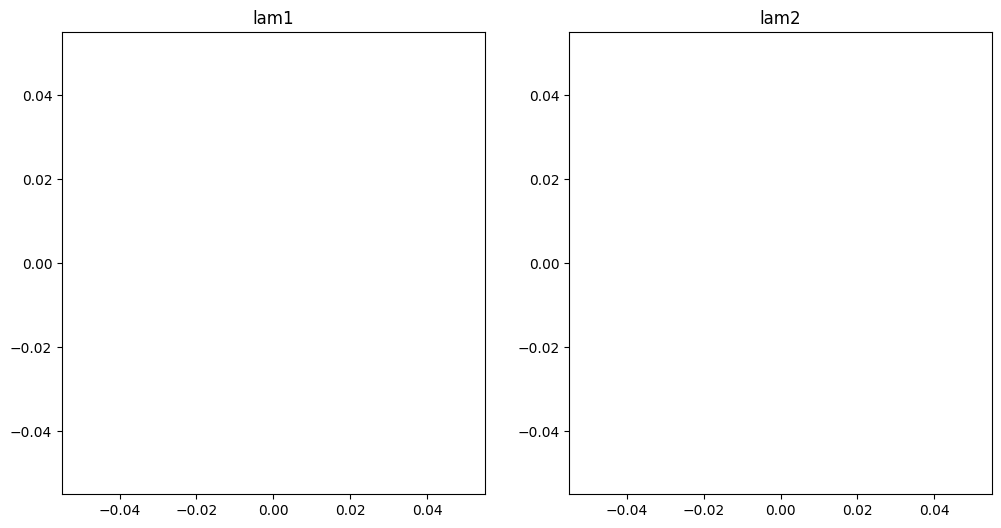

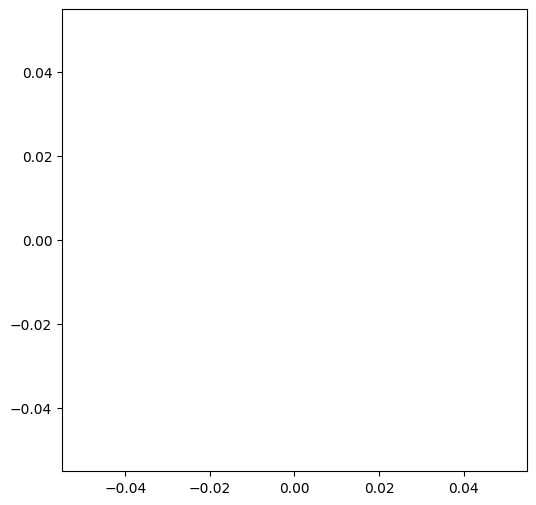

Step: 250, Loss: 0.2730041742324829
Data loss: 0.27204880118370056, Phi loss: 0.0009553621057420969
Lam1: 2.9982, lam2: 0.4969
Step: 500, Loss: 0.2500254511833191
Data loss: 0.2476242035627365, Phi loss: 0.002401243429630995
Lam1: 3.0001, lam2: 0.493
Step: 750, Loss: 0.2334468513727188
Data loss: 0.22383709251880646, Phi loss: 0.009609752334654331
Lam1: 3.006, lam2: 0.4879
Step: 1000, Loss: 0.22346769273281097
Data loss: 0.20926962792873383, Phi loss: 0.014198064804077148
Lam1: 3.0109, lam2: 0.4837
Step: 1250, Loss: 0.21495750546455383
Data loss: 0.19901514053344727, Phi loss: 0.015942368656396866
Lam1: 3.0153, lam2: 0.4804
Step: 1500, Loss: 0.20730416476726532
Data loss: 0.19056880474090576, Phi loss: 0.016735365614295006
Lam1: 3.0194, lam2: 0.4772
Step: 1750, Loss: 0.19958096742630005
Data loss: 0.1817304491996765, Phi loss: 0.017850510776042938
Lam1: 3.0234, lam2: 0.4735
Step: 2000, Loss: 0.1897856593132019
Data loss: 0.169468492269516, Phi loss: 0.02031717449426651
Lam1: 3.0276, la

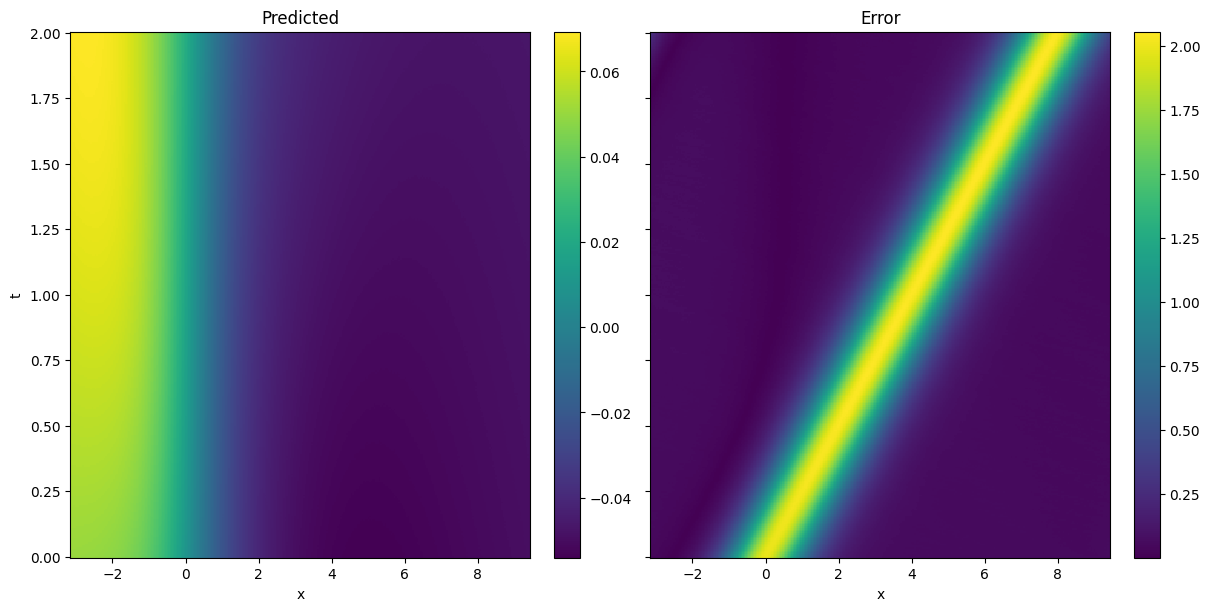

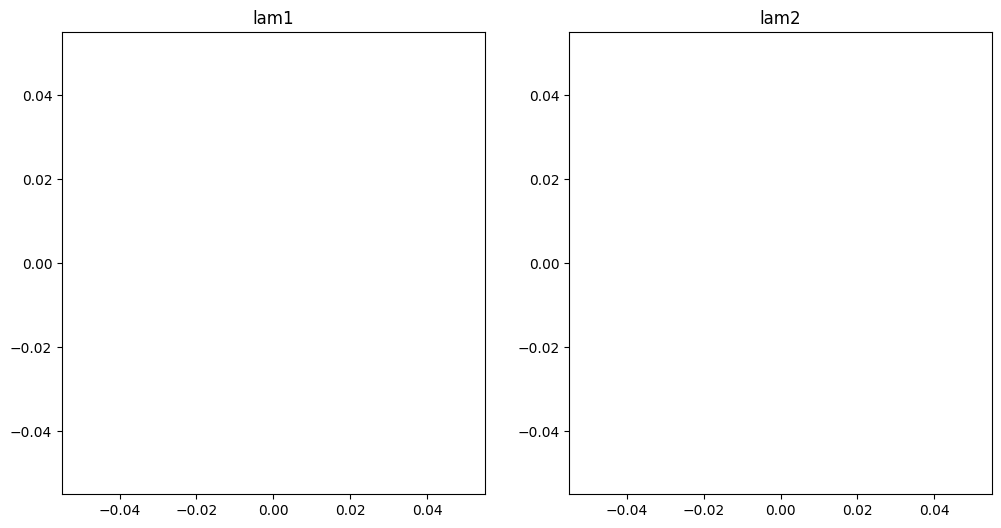

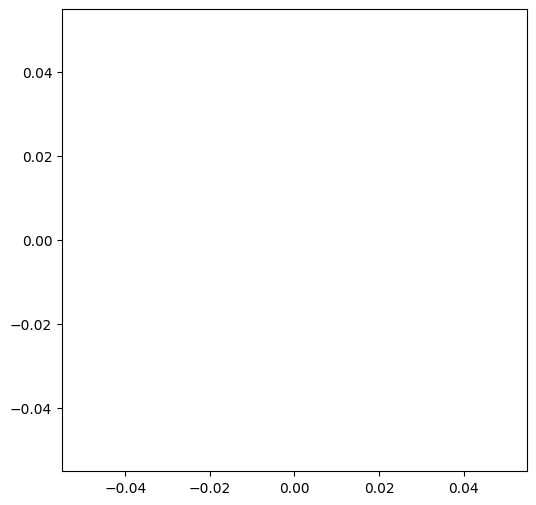

Step: 250, Loss: 0.2589235007762909
Data loss: 0.25674688816070557, Phi loss: 0.002176610752940178
Lam1: 2.9996, lam2: 0.4983
Step: 500, Loss: 0.2290920466184616
Data loss: 0.2159508466720581, Phi loss: 0.013141203671693802
Lam1: 3.0047, lam2: 0.4932
Step: 750, Loss: 0.21769823133945465
Data loss: 0.20226897299289703, Phi loss: 0.01542925275862217
Lam1: 3.0091, lam2: 0.4896
Step: 1000, Loss: 0.2098696231842041
Data loss: 0.19376599788665771, Phi loss: 0.016103625297546387
Lam1: 3.0131, lam2: 0.4855
Step: 1250, Loss: 0.20258793234825134
Data loss: 0.18532834947109222, Phi loss: 0.01725957915186882
Lam1: 3.017, lam2: 0.4812
Step: 1500, Loss: 0.19492138922214508
Data loss: 0.17488884925842285, Phi loss: 0.020032543689012527
Lam1: 3.0208, lam2: 0.4772
Step: 1750, Loss: 0.18599866330623627
Data loss: 0.16218607127666473, Phi loss: 0.023812592029571533
Lam1: 3.0248, lam2: 0.4735
Step: 2000, Loss: 0.17238415777683258
Data loss: 0.1430787295103073, Phi loss: 0.02930542267858982
Lam1: 3.0293, l

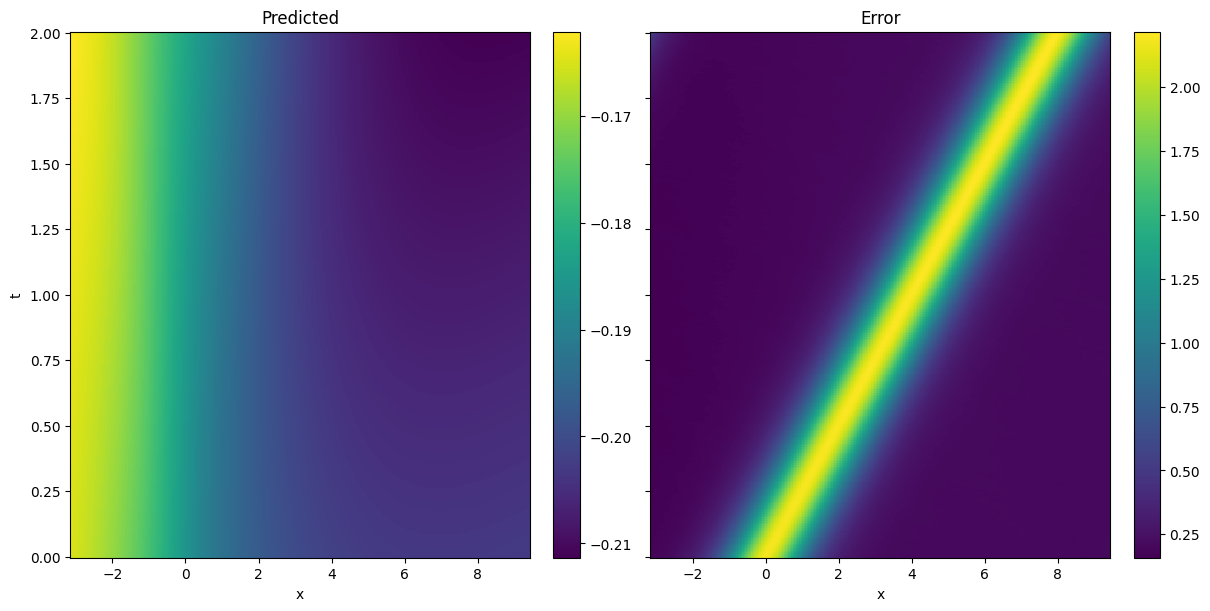

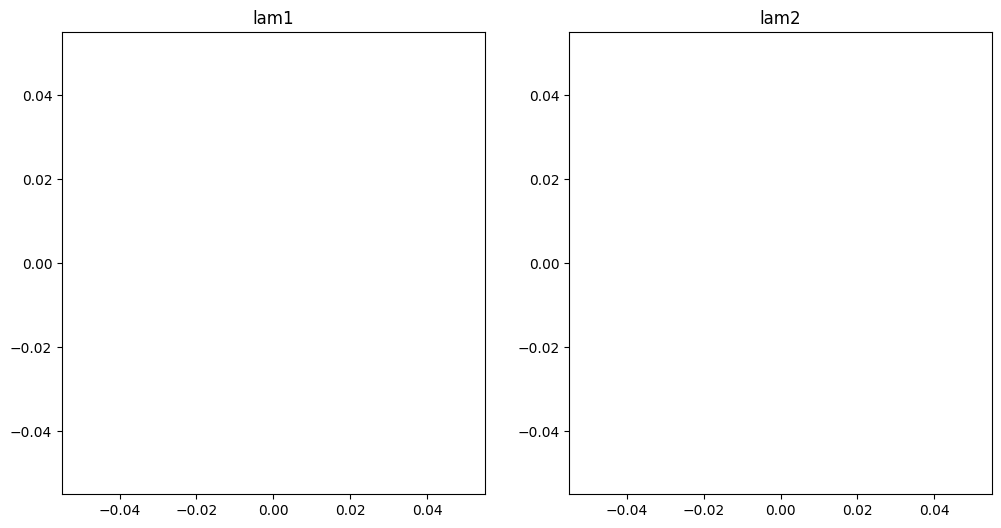

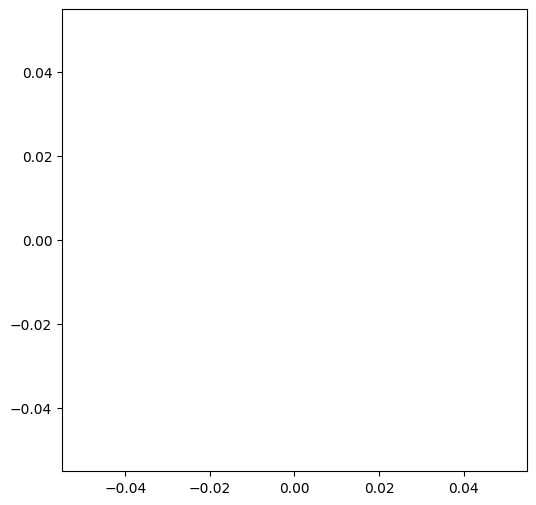

Step: 250, Loss: 0.47017988562583923
Data loss: 0.4701476991176605, Phi loss: 3.2179905247176066e-05
Lam1: 2.9986, lam2: 0.4988
Step: 500, Loss: 0.3923565149307251
Data loss: 0.39220255613327026, Phi loss: 0.00015395200171042234
Lam1: 3.0011, lam2: 0.5034
Step: 750, Loss: 0.3300027847290039
Data loss: 0.32928162813186646, Phi loss: 0.0007211700431071222
Lam1: 2.9969, lam2: 0.5096
Step: 1000, Loss: 0.3000439703464508
Data loss: 0.29818716645240784, Phi loss: 0.001856811810284853
Lam1: 2.9895, lam2: 0.5157
Step: 1250, Loss: 0.29210808873176575
Data loss: 0.2897431552410126, Phi loss: 0.002364934189245105
Lam1: 2.9837, lam2: 0.5207
Step: 1500, Loss: 0.2890371084213257
Data loss: 0.28709959983825684, Phi loss: 0.0019375174306333065
Lam1: 2.9794, lam2: 0.5245
Step: 1750, Loss: 0.28649961948394775
Data loss: 0.2852230668067932, Phi loss: 0.0012765662977471948
Lam1: 2.9761, lam2: 0.5273
Step: 2000, Loss: 0.2840600907802582
Data loss: 0.2833576798439026, Phi loss: 0.0007024059887044132
Lam1: 2

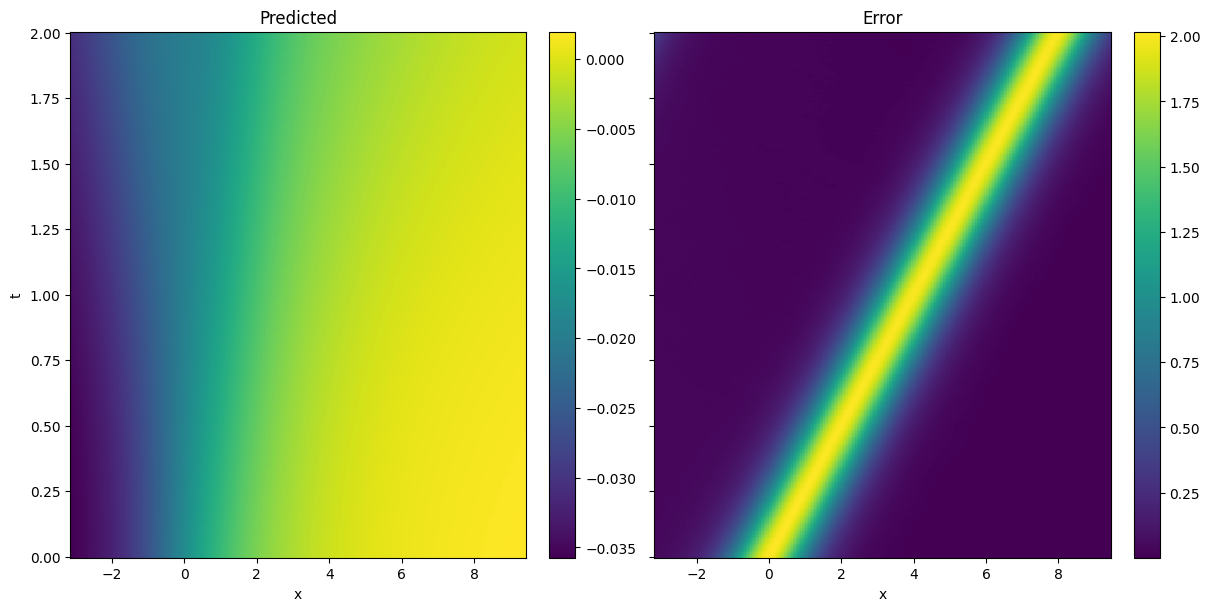

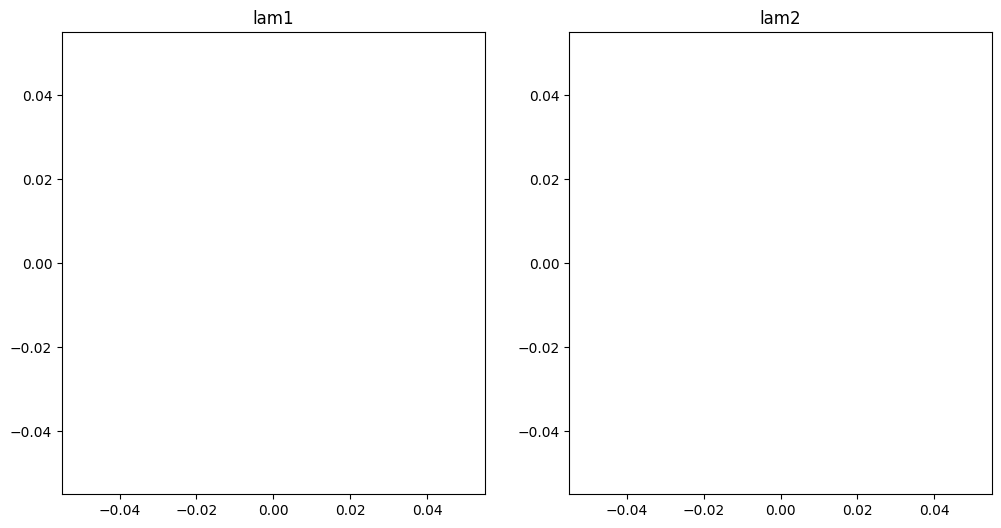

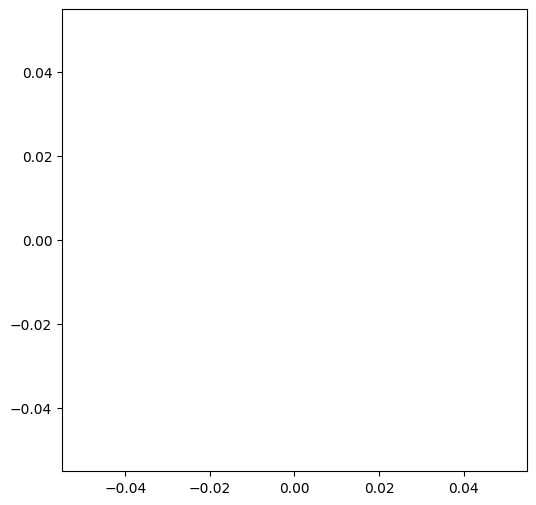

Step: 250, Loss: 0.318700909614563
Data loss: 0.31847161054611206, Phi loss: 0.00022930154227651656
Lam1: 2.9973, lam2: 0.5033
Step: 500, Loss: 0.28368934988975525
Data loss: 0.28256505727767944, Phi loss: 0.001124288304708898
Lam1: 2.9911, lam2: 0.5088
Step: 750, Loss: 0.27464592456817627
Data loss: 0.2741355895996094, Phi loss: 0.0005103246076032519
Lam1: 2.9877, lam2: 0.5091
Step: 1000, Loss: 0.25693830847740173
Data loss: 0.25585851073265076, Phi loss: 0.0010797936702147126
Lam1: 2.989, lam2: 0.5029
Step: 1250, Loss: 0.23214787244796753
Data loss: 0.2245168387889862, Phi loss: 0.007631037384271622
Lam1: 2.9961, lam2: 0.4963
Step: 1500, Loss: 0.22082266211509705
Data loss: 0.2074364572763443, Phi loss: 0.013386203907430172
Lam1: 3.0021, lam2: 0.4909
Step: 1750, Loss: 0.21387775242328644
Data loss: 0.19832080602645874, Phi loss: 0.01555695291608572
Lam1: 3.0067, lam2: 0.4869
Step: 2000, Loss: 0.20743557810783386
Data loss: 0.19073344767093658, Phi loss: 0.01670212298631668
Lam1: 3.01

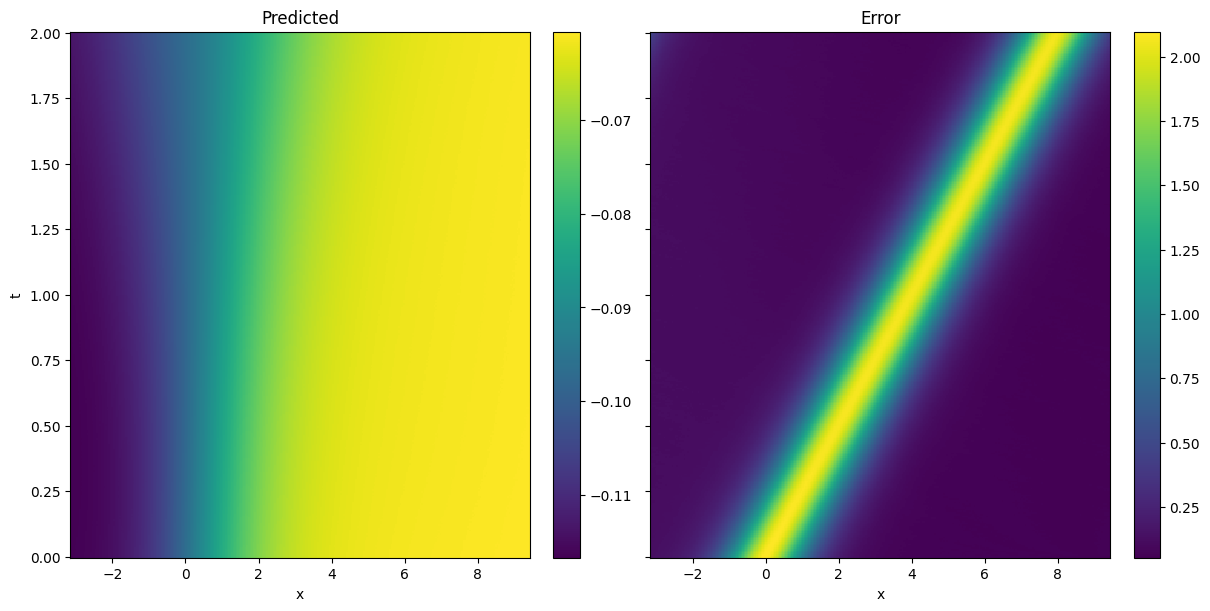

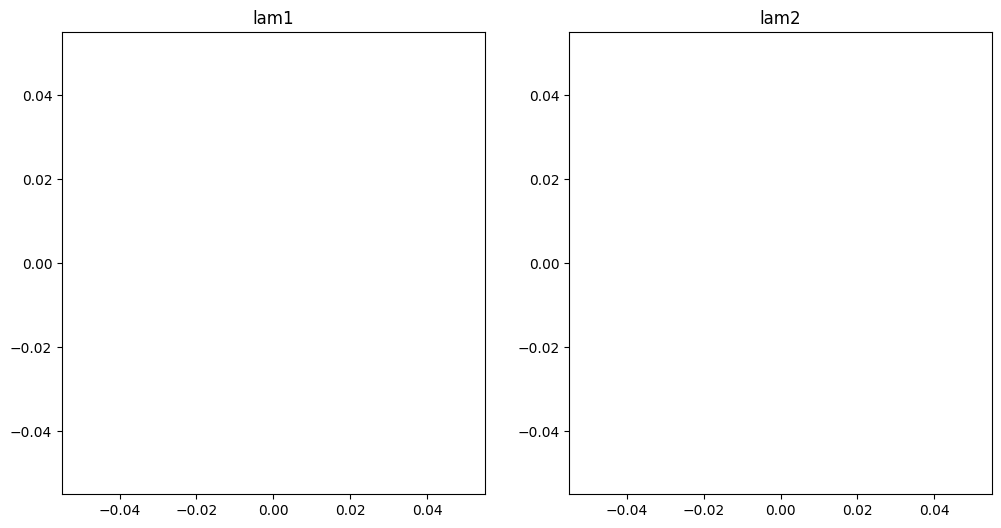

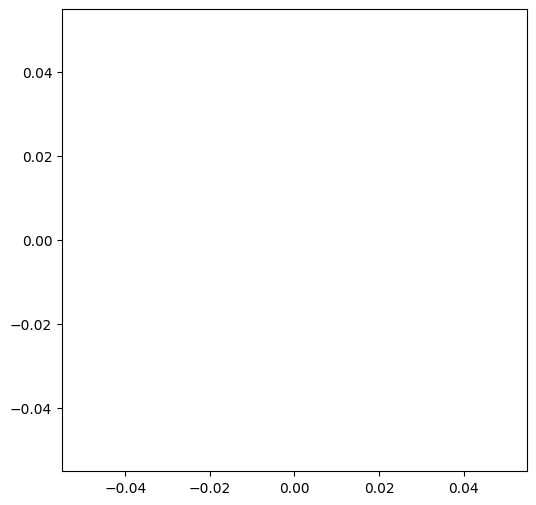

Step: 250, Loss: 0.28896862268447876
Data loss: 0.28743091225624084, Phi loss: 0.0015377210220322013
Lam1: 2.9983, lam2: 0.5021
Step: 500, Loss: 0.26879939436912537
Data loss: 0.2680445611476898, Phi loss: 0.0007548244320787489
Lam1: 2.9968, lam2: 0.503
Step: 750, Loss: 0.24391470849514008
Data loss: 0.23842088878154755, Phi loss: 0.005493820644915104
Lam1: 3.0022, lam2: 0.4972
Step: 1000, Loss: 0.2251998782157898
Data loss: 0.21146611869335175, Phi loss: 0.013733758591115475
Lam1: 3.0076, lam2: 0.4918
Step: 1250, Loss: 0.2173360288143158
Data loss: 0.20141950249671936, Phi loss: 0.015916524454951286
Lam1: 3.0124, lam2: 0.4878
Step: 1500, Loss: 0.21177467703819275
Data loss: 0.1955498456954956, Phi loss: 0.016224823892116547
Lam1: 3.0166, lam2: 0.4839
Step: 1750, Loss: 0.20598652958869934
Data loss: 0.18938098847866058, Phi loss: 0.016605539247393608
Lam1: 3.0205, lam2: 0.4799
Step: 2000, Loss: 0.19897422194480896
Data loss: 0.1812131106853485, Phi loss: 0.01776111125946045
Lam1: 3.024

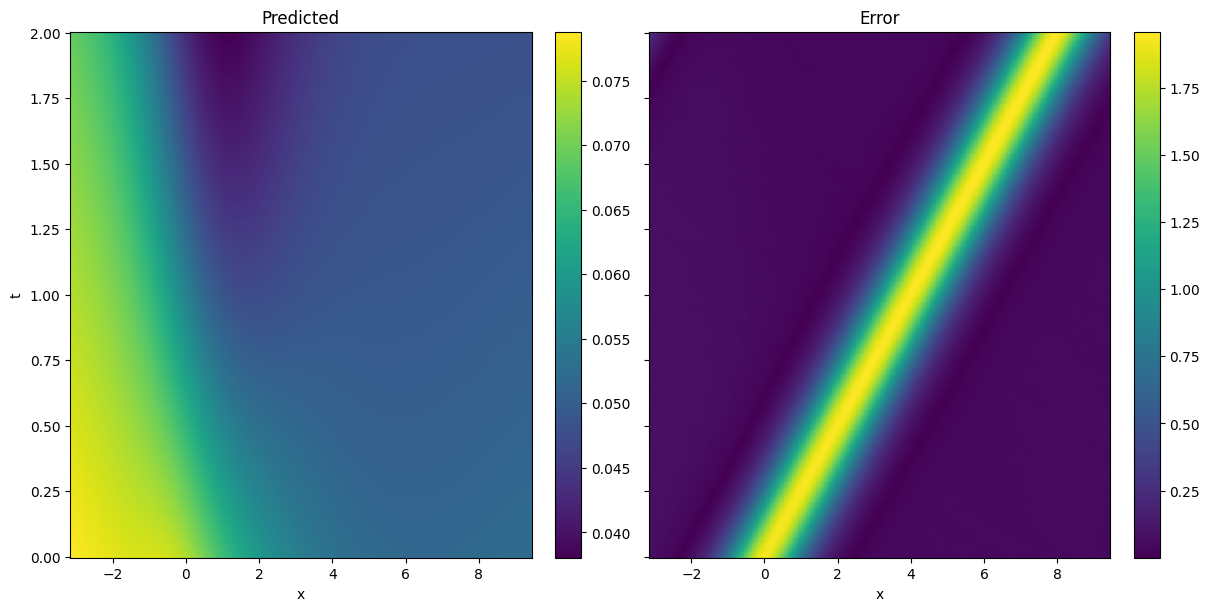

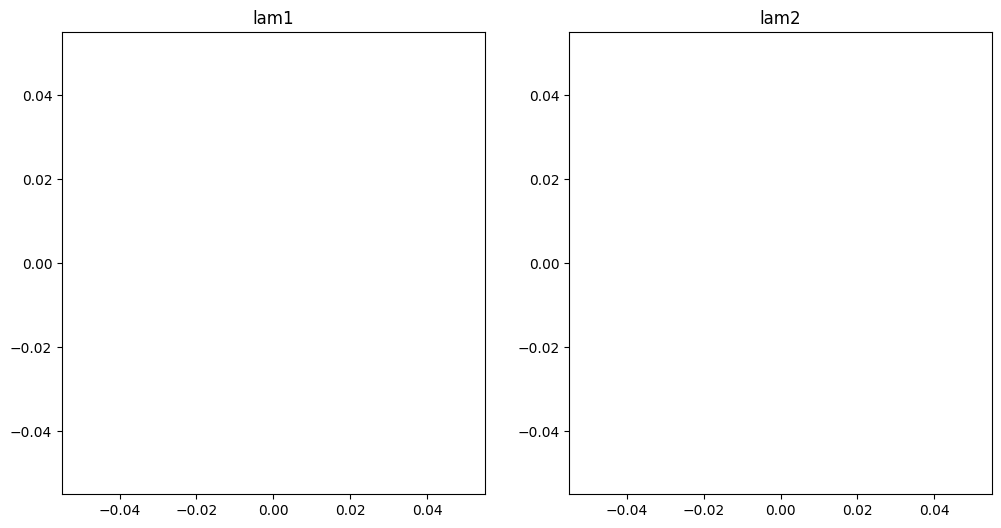

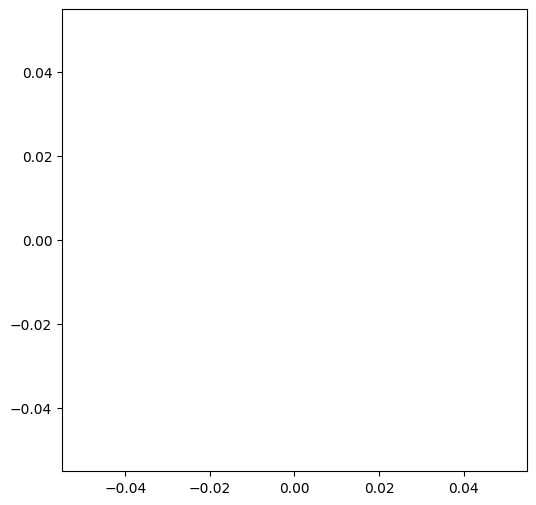

Step: 250, Loss: 0.24609513580799103
Data loss: 0.24073822796344757, Phi loss: 0.005356903187930584
Lam1: 3.0004, lam2: 0.4956
Step: 500, Loss: 0.21872930228710175
Data loss: 0.2031775414943695, Phi loss: 0.015551755204796791
Lam1: 3.0054, lam2: 0.4908
Step: 750, Loss: 0.20785872638225555
Data loss: 0.19219696521759033, Phi loss: 0.015661755576729774
Lam1: 3.0095, lam2: 0.4869
Step: 1000, Loss: 0.196417897939682
Data loss: 0.17716985940933228, Phi loss: 0.01924804598093033
Lam1: 3.0135, lam2: 0.4829
Step: 1250, Loss: 0.18628576397895813
Data loss: 0.16217908263206482, Phi loss: 0.024106675758957863
Lam1: 3.0176, lam2: 0.4788
Step: 1500, Loss: 0.15761815011501312
Data loss: 0.12301629781723022, Phi loss: 0.0346018485724926
Lam1: 3.0229, lam2: 0.4732
Step: 1750, Loss: 0.13277076184749603
Data loss: 0.09811153262853622, Phi loss: 0.03465923294425011
Lam1: 3.0291, lam2: 0.4666
Step: 2000, Loss: 0.11595073342323303
Data loss: 0.09166547656059265, Phi loss: 0.02428525686264038
Lam1: 3.034, l

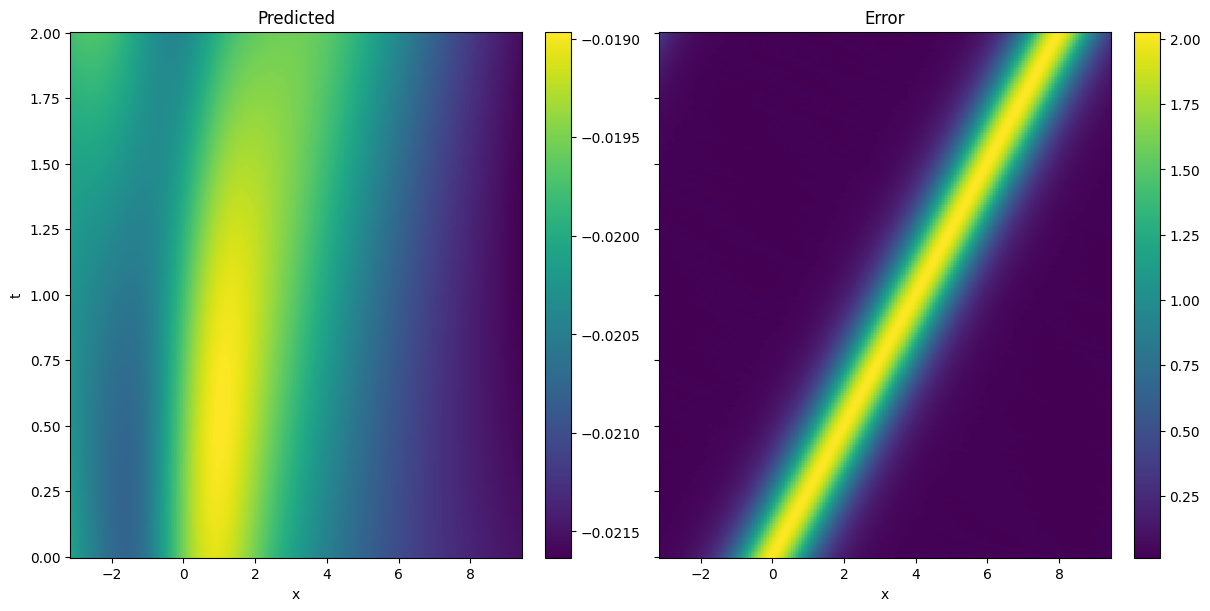

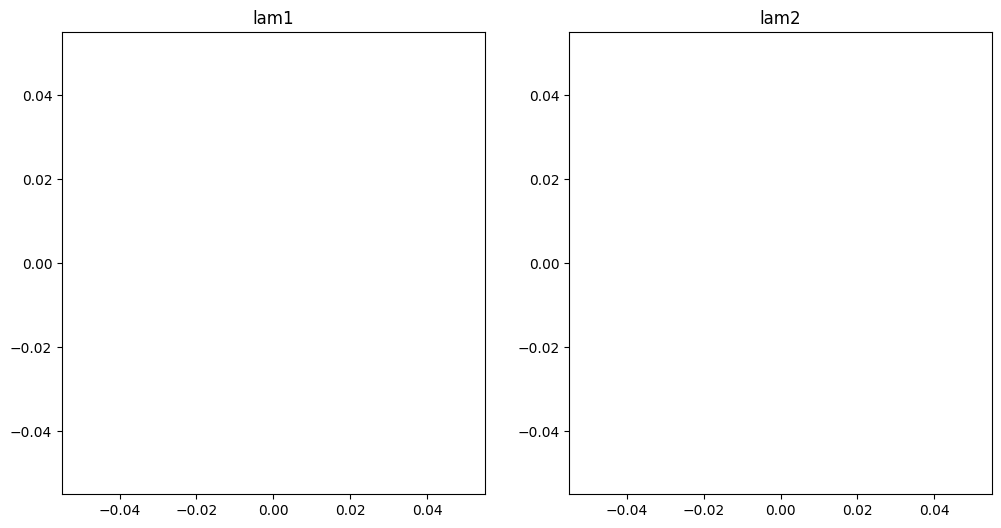

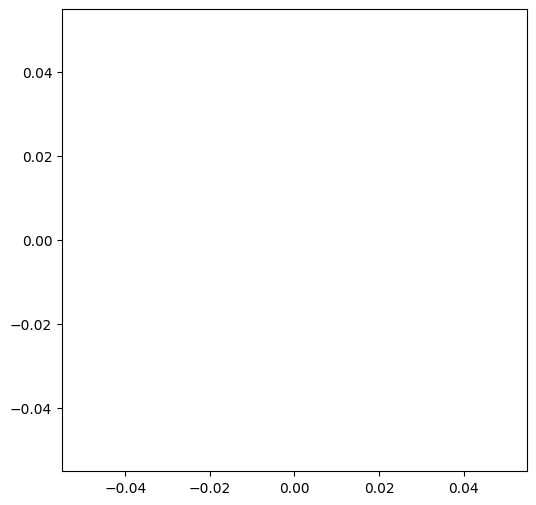

Step: 250, Loss: 0.36324331164360046
Data loss: 0.36324161291122437, Phi loss: 1.7067195585696027e-06
Lam1: 2.9993, lam2: 0.4969
Step: 500, Loss: 0.32442334294319153
Data loss: 0.32440170645713806, Phi loss: 2.164028956030961e-05
Lam1: 2.9924, lam2: 0.4931
Step: 750, Loss: 0.2958095967769623
Data loss: 0.29563528299331665, Phi loss: 0.00017432575987186283
Lam1: 2.9851, lam2: 0.4883
Step: 1000, Loss: 0.28494179248809814
Data loss: 0.28452610969543457, Phi loss: 0.0004156684735789895
Lam1: 2.9787, lam2: 0.4801
Step: 1250, Loss: 0.2822088599205017
Data loss: 0.28181180357933044, Phi loss: 0.00039705095696263015
Lam1: 2.9741, lam2: 0.4736
Step: 1500, Loss: 0.2802121937274933
Data loss: 0.2798970937728882, Phi loss: 0.0003151137207169086
Lam1: 2.9713, lam2: 0.4686
Step: 1750, Loss: 0.27766814827919006
Data loss: 0.27734172344207764, Phi loss: 0.000326421664794907
Lam1: 2.9702, lam2: 0.4645
Step: 2000, Loss: 0.2734960615634918
Data loss: 0.2729233205318451, Phi loss: 0.00057273730635643
Lam1

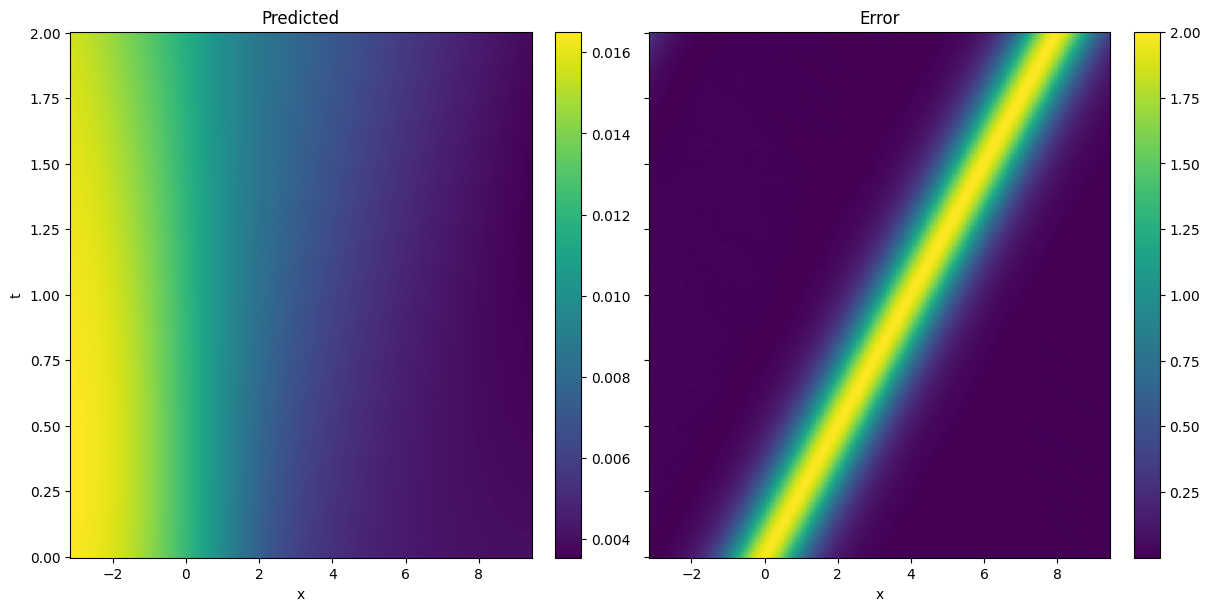

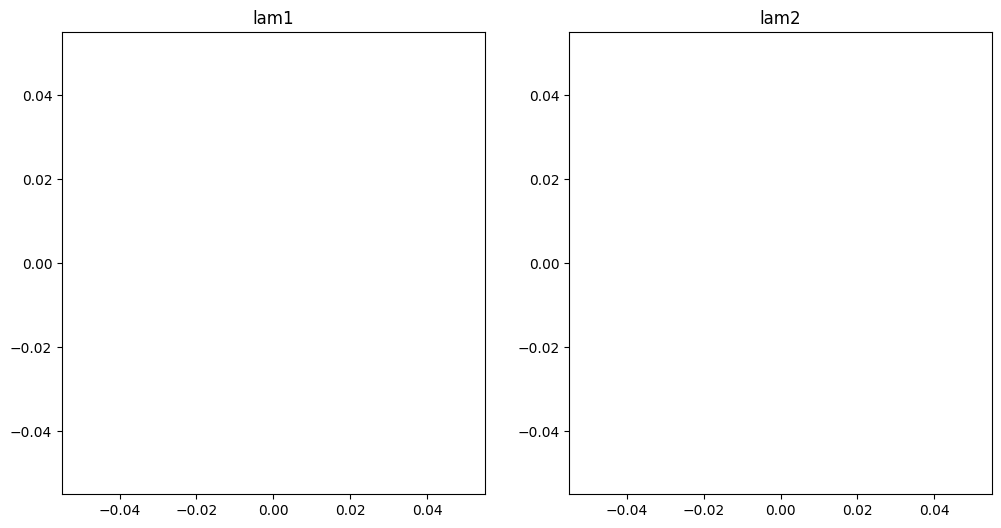

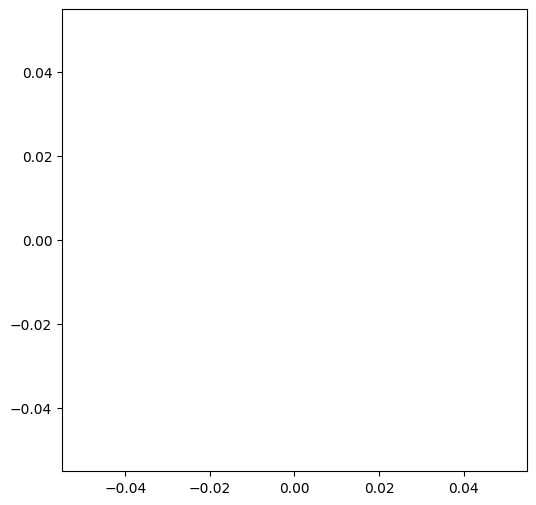

Step: 250, Loss: 0.31986796855926514
Data loss: 0.3198266327381134, Phi loss: 4.134077607886866e-05
Lam1: 2.9981, lam2: 0.496
Step: 500, Loss: 0.2810668349266052
Data loss: 0.28070417046546936, Phi loss: 0.0003626761317718774
Lam1: 2.9912, lam2: 0.4896
Step: 750, Loss: 0.2722487449645996
Data loss: 0.271854430437088, Phi loss: 0.0003943006449844688
Lam1: 2.9894, lam2: 0.4839
Step: 1000, Loss: 0.24929524958133698
Data loss: 0.24567201733589172, Phi loss: 0.0036232357379049063
Lam1: 2.9955, lam2: 0.4784
Step: 1250, Loss: 0.22943215072155
Data loss: 0.21796749532222748, Phi loss: 0.011464656330645084
Lam1: 3.0023, lam2: 0.4723
Step: 1500, Loss: 0.22023943066596985
Data loss: 0.20676681399345398, Phi loss: 0.013472618535161018
Lam1: 3.0072, lam2: 0.468
Step: 1750, Loss: 0.21452677249908447
Data loss: 0.19940140843391418, Phi loss: 0.015125365927815437
Lam1: 3.0114, lam2: 0.4645
Step: 2000, Loss: 0.21017661690711975
Data loss: 0.19461572170257568, Phi loss: 0.015560895204544067
Lam1: 3.0152

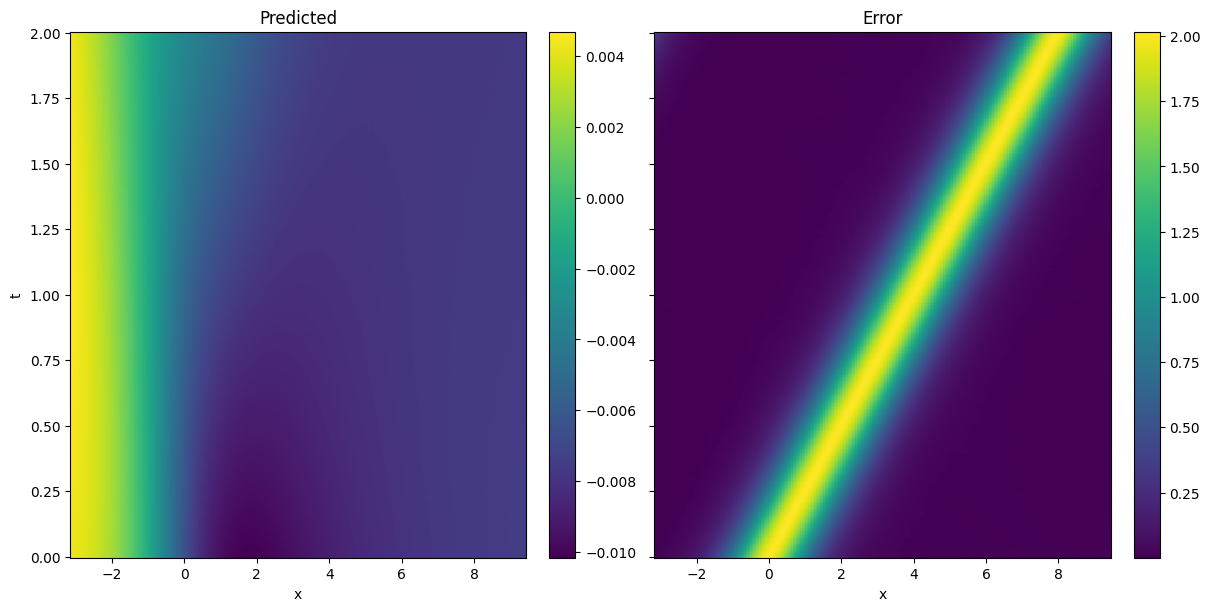

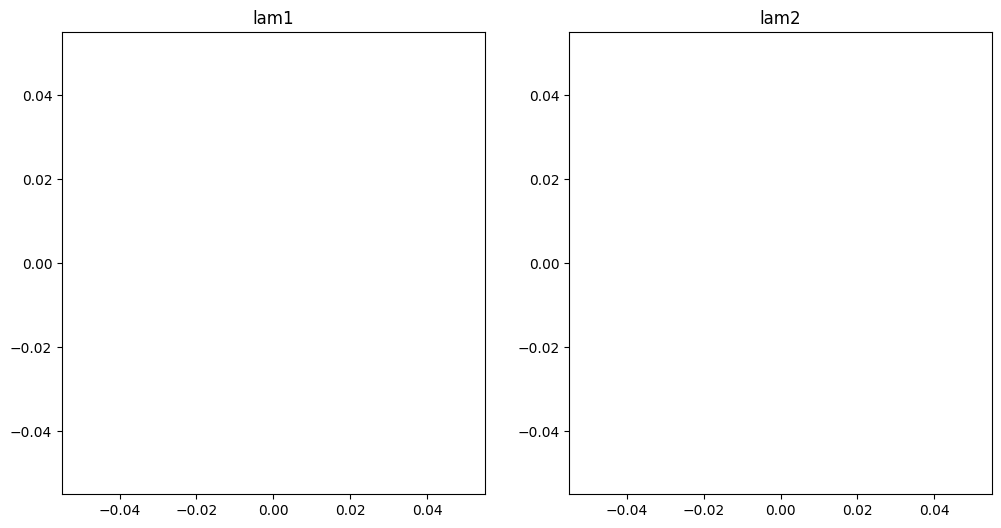

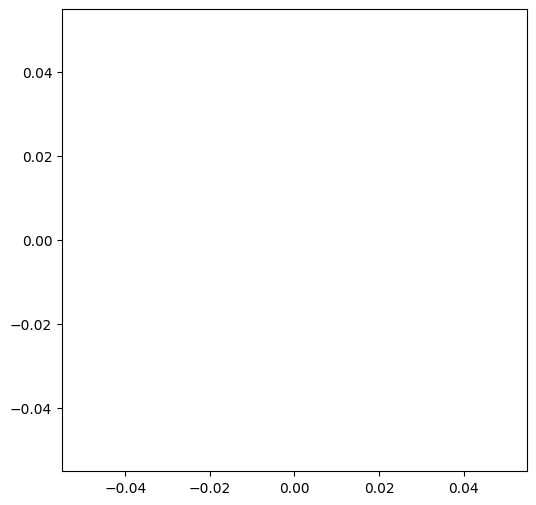

Step: 250, Loss: 0.2847108840942383
Data loss: 0.2841532230377197, Phi loss: 0.0005576586117967963
Lam1: 2.9952, lam2: 0.4951
Step: 500, Loss: 0.27281033992767334
Data loss: 0.2716572880744934, Phi loss: 0.0011530561605468392
Lam1: 2.9952, lam2: 0.4903
Step: 750, Loss: 0.23749586939811707
Data loss: 0.2277000993490219, Phi loss: 0.009795771911740303
Lam1: 3.0012, lam2: 0.4847
Step: 1000, Loss: 0.21978160738945007
Data loss: 0.20317578315734863, Phi loss: 0.01660582609474659
Lam1: 3.0068, lam2: 0.4802
Step: 1250, Loss: 0.2127160131931305
Data loss: 0.1963435560464859, Phi loss: 0.01637246459722519
Lam1: 3.0113, lam2: 0.4763
Step: 1500, Loss: 0.20500414073467255
Data loss: 0.18841321766376495, Phi loss: 0.016590919345617294
Lam1: 3.0155, lam2: 0.4721
Step: 1750, Loss: 0.19571559131145477
Data loss: 0.17637808620929718, Phi loss: 0.01933750882744789
Lam1: 3.0196, lam2: 0.468
Step: 2000, Loss: 0.18740706145763397
Data loss: 0.16401486098766327, Phi loss: 0.023392194882035255
Lam1: 3.0238, 

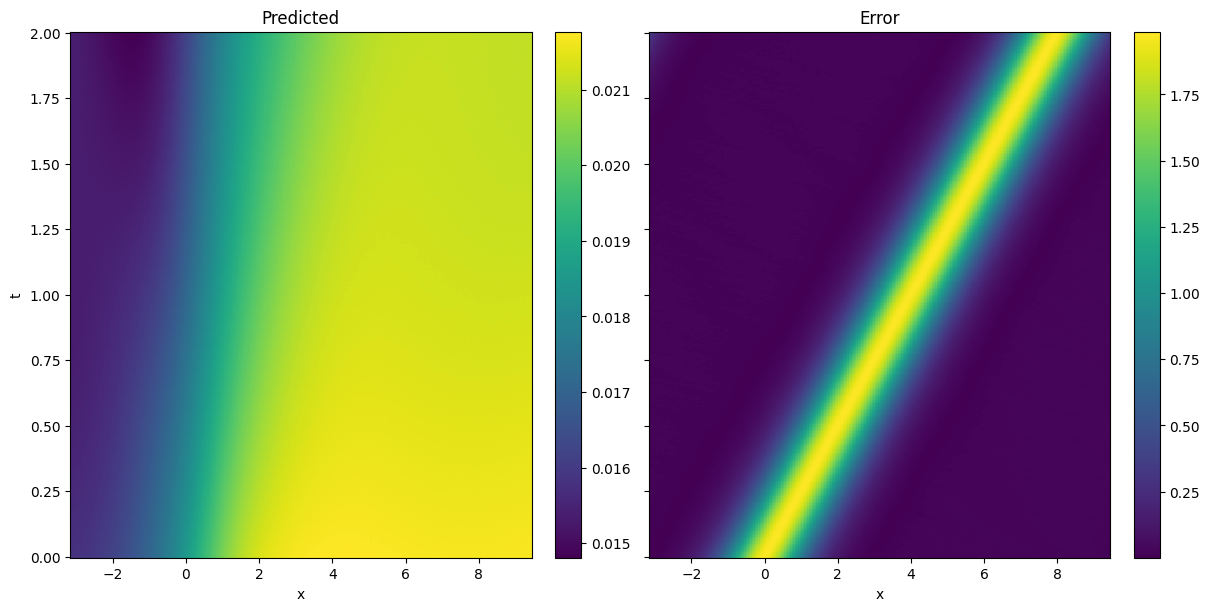

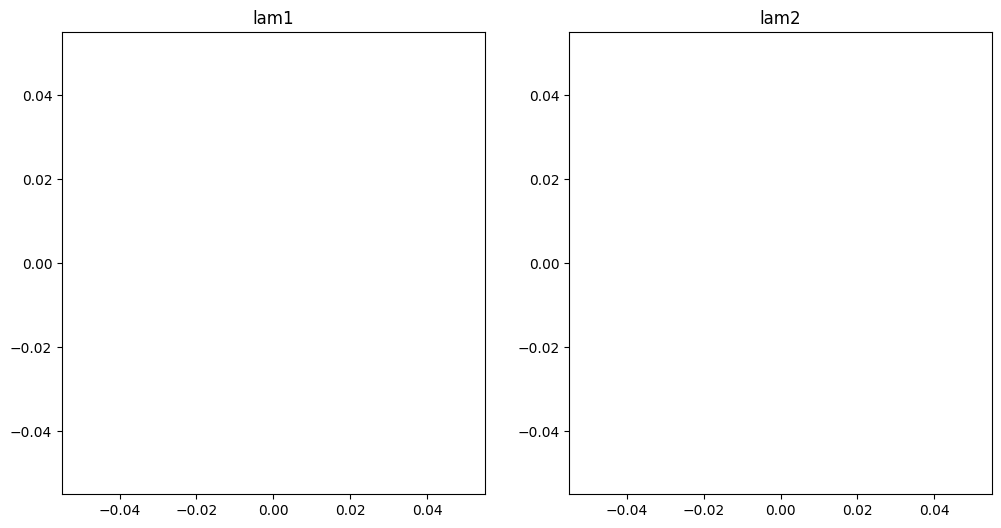

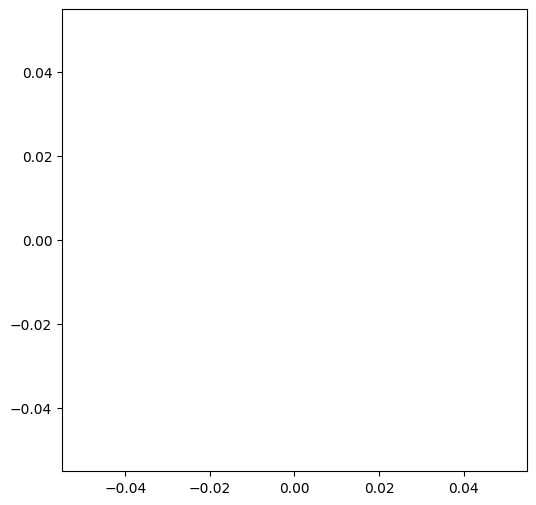

Step: 250, Loss: 0.2488020807504654
Data loss: 0.24379710853099823, Phi loss: 0.00500496756285429
Lam1: 3.0009, lam2: 0.4955
Step: 500, Loss: 0.21116343140602112
Data loss: 0.19416813552379608, Phi loss: 0.016995294019579887
Lam1: 3.0063, lam2: 0.4907
Step: 750, Loss: 0.19353576004505157
Data loss: 0.1735658496618271, Phi loss: 0.019969912245869637
Lam1: 3.0106, lam2: 0.4861
Step: 1000, Loss: 0.17290416359901428
Data loss: 0.14277632534503937, Phi loss: 0.030127841979265213
Lam1: 3.0155, lam2: 0.4813
Step: 1250, Loss: 0.14278526604175568
Data loss: 0.1074269637465477, Phi loss: 0.03535829856991768
Lam1: 3.0214, lam2: 0.4752
Step: 1500, Loss: 0.12563607096672058
Data loss: 0.09713808447122574, Phi loss: 0.028497984632849693
Lam1: 3.0264, lam2: 0.47
Step: 1750, Loss: 0.11609181761741638
Data loss: 0.09329298883676529, Phi loss: 0.022798830643296242
Lam1: 3.0305, lam2: 0.4658
Step: 2000, Loss: 0.11222777515649796
Data loss: 0.09272042661905289, Phi loss: 0.019507350400090218
Lam1: 3.0341,

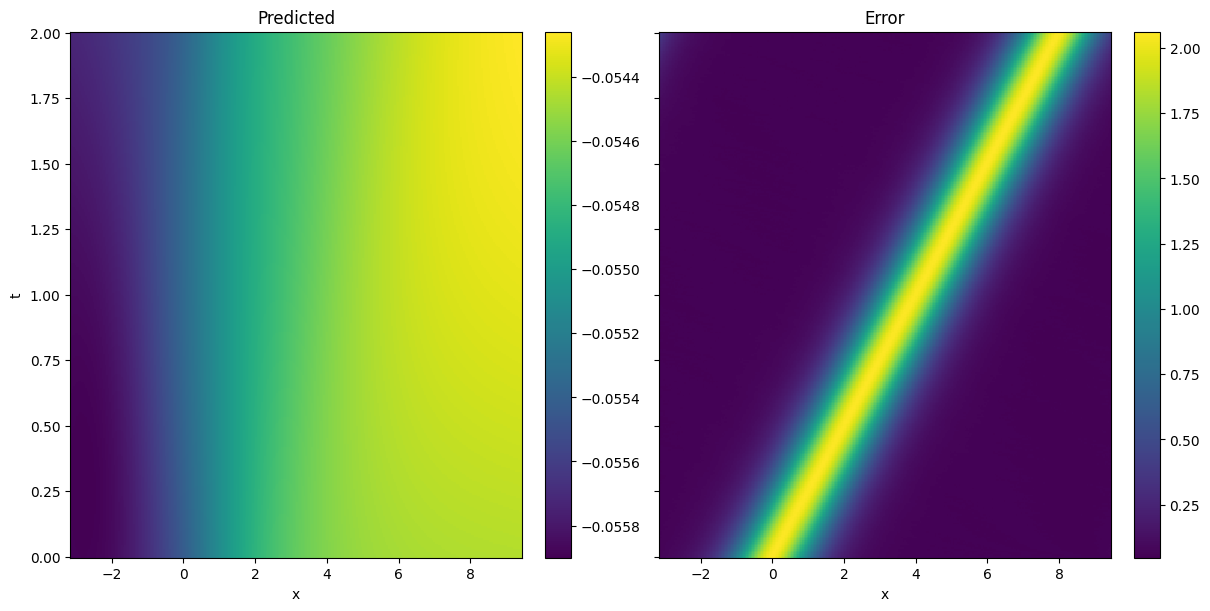

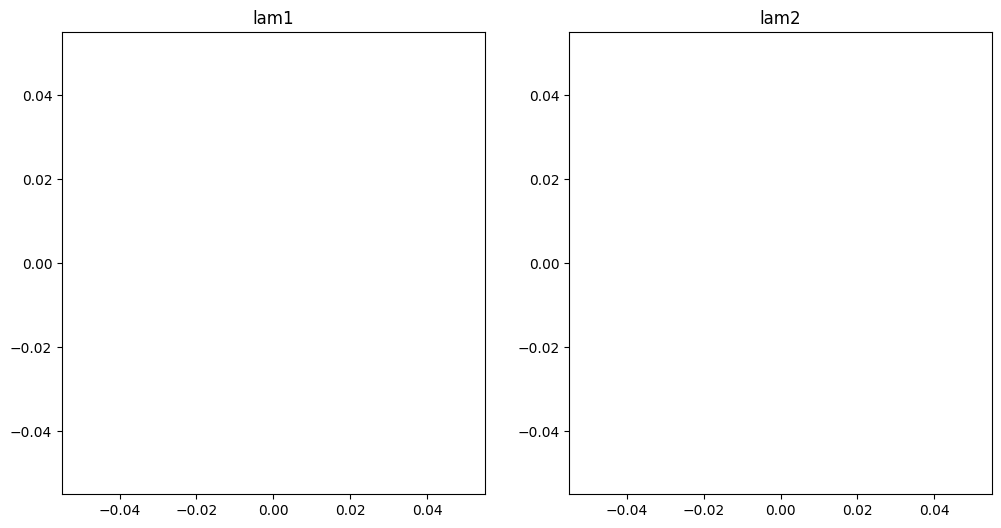

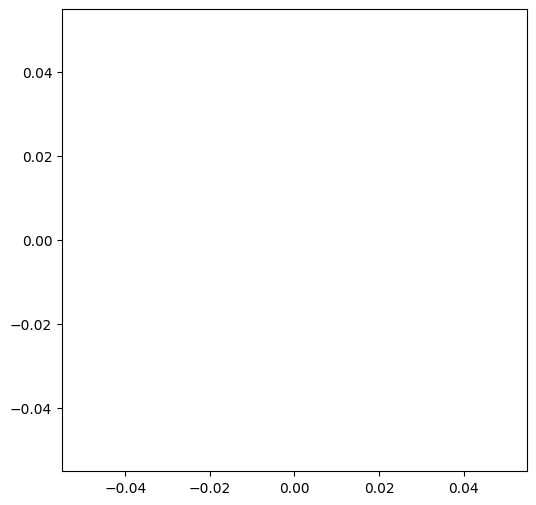

Step: 250, Loss: 0.3911118507385254
Data loss: 0.391111820936203, Phi loss: 3.86142176012072e-08
Lam1: 3.0, lam2: 0.4993
Step: 500, Loss: 0.3551848232746124
Data loss: 0.3551843464374542, Phi loss: 4.811940357285494e-07
Lam1: 2.9976, lam2: 0.4952
Step: 750, Loss: 0.3226088583469391
Data loss: 0.3225981593132019, Phi loss: 1.0707259207265452e-05
Lam1: 2.99, lam2: 0.4876
Step: 1000, Loss: 0.2972846031188965
Data loss: 0.2971367835998535, Phi loss: 0.00014780907076783478
Lam1: 2.9814, lam2: 0.4789
Step: 1250, Loss: 0.2846786379814148
Data loss: 0.2841812074184418, Phi loss: 0.0004974264302290976
Lam1: 2.9744, lam2: 0.4703
Step: 1500, Loss: 0.280575156211853
Data loss: 0.27997031807899475, Phi loss: 0.0006048281793482602
Lam1: 2.9711, lam2: 0.4638
Step: 1750, Loss: 0.2785816490650177
Data loss: 0.2778751254081726, Phi loss: 0.0007065156241878867
Lam1: 2.9737, lam2: 0.4595
Step: 2000, Loss: 0.2772485017776489
Data loss: 0.2761791944503784, Phi loss: 0.0010693061631172895
Lam1: 2.9795, lam2:

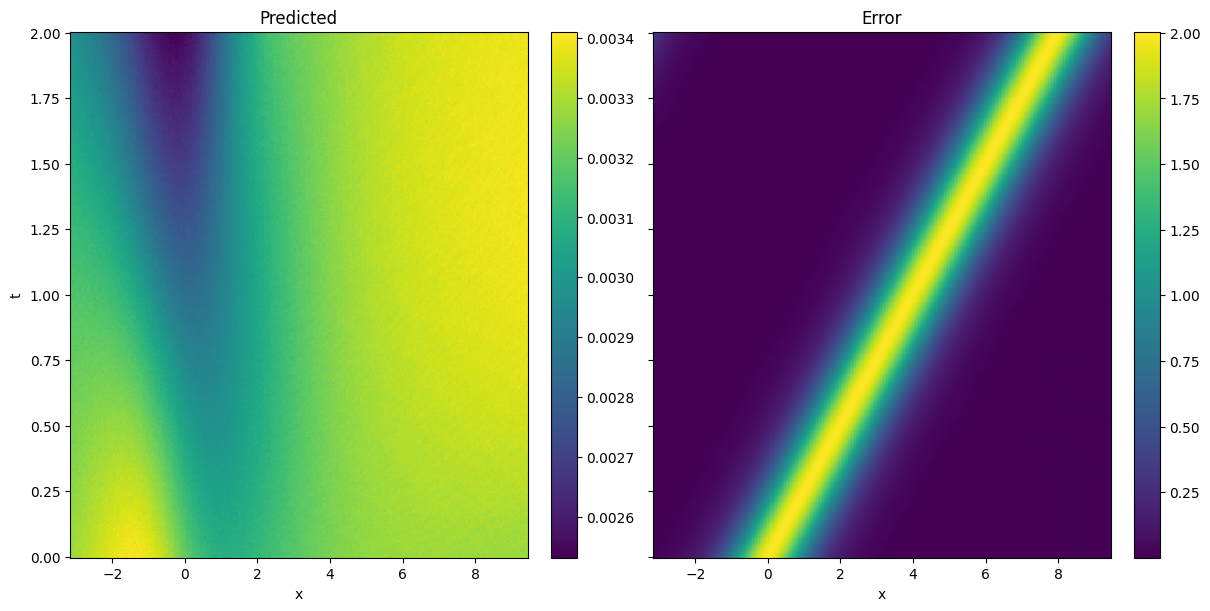

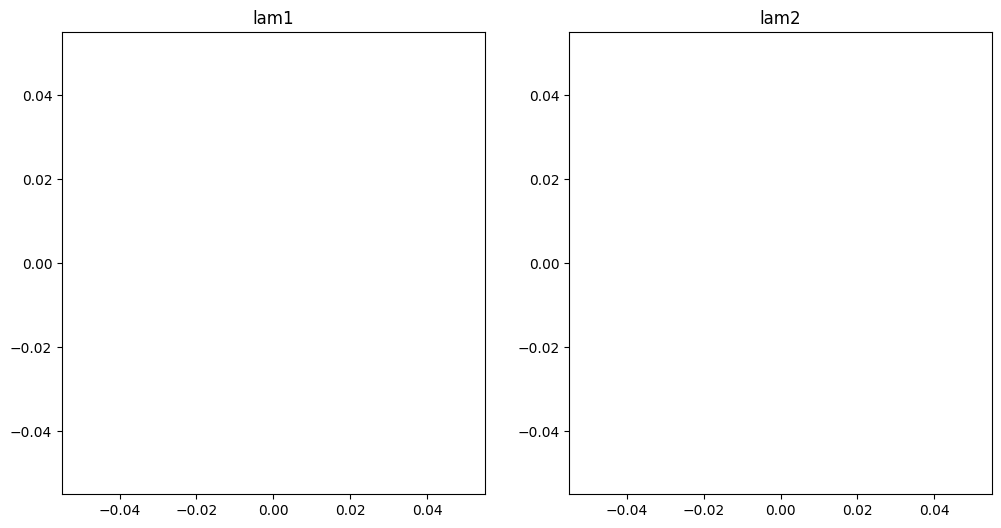

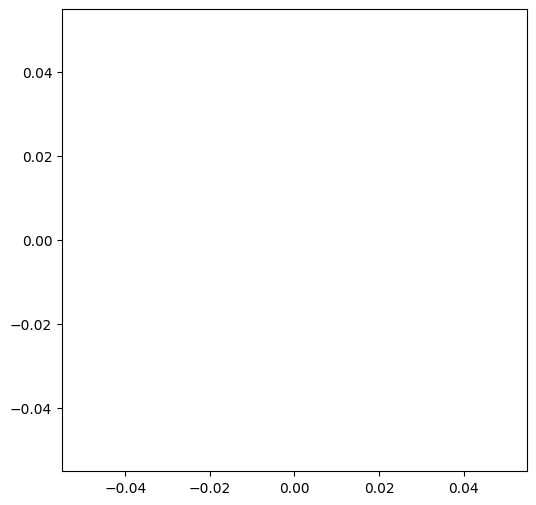

Step: 250, Loss: 0.32808953523635864
Data loss: 0.3280794322490692, Phi loss: 1.0092081538459752e-05
Lam1: 2.9975, lam2: 0.496
Step: 500, Loss: 0.284715473651886
Data loss: 0.28421345353126526, Phi loss: 0.0005020301323384047
Lam1: 2.9901, lam2: 0.4883
Step: 750, Loss: 0.2787474989891052
Data loss: 0.27815502882003784, Phi loss: 0.0005924745346419513
Lam1: 2.9879, lam2: 0.4822
Step: 1000, Loss: 0.27278396487236023
Data loss: 0.2706005871295929, Phi loss: 0.002183382399380207
Lam1: 2.9928, lam2: 0.4779
Step: 1250, Loss: 0.24754957854747772
Data loss: 0.24127285182476044, Phi loss: 0.006276720203459263
Lam1: 2.9987, lam2: 0.4732
Step: 1500, Loss: 0.2298414260149002
Data loss: 0.217178612947464, Phi loss: 0.012662815861403942
Lam1: 3.0047, lam2: 0.4678
Step: 1750, Loss: 0.22341755032539368
Data loss: 0.20902839303016663, Phi loss: 0.014389154501259327
Lam1: 3.0092, lam2: 0.4642
Step: 2000, Loss: 0.21842971444129944
Data loss: 0.2029600590467453, Phi loss: 0.015469659119844437
Lam1: 3.0132

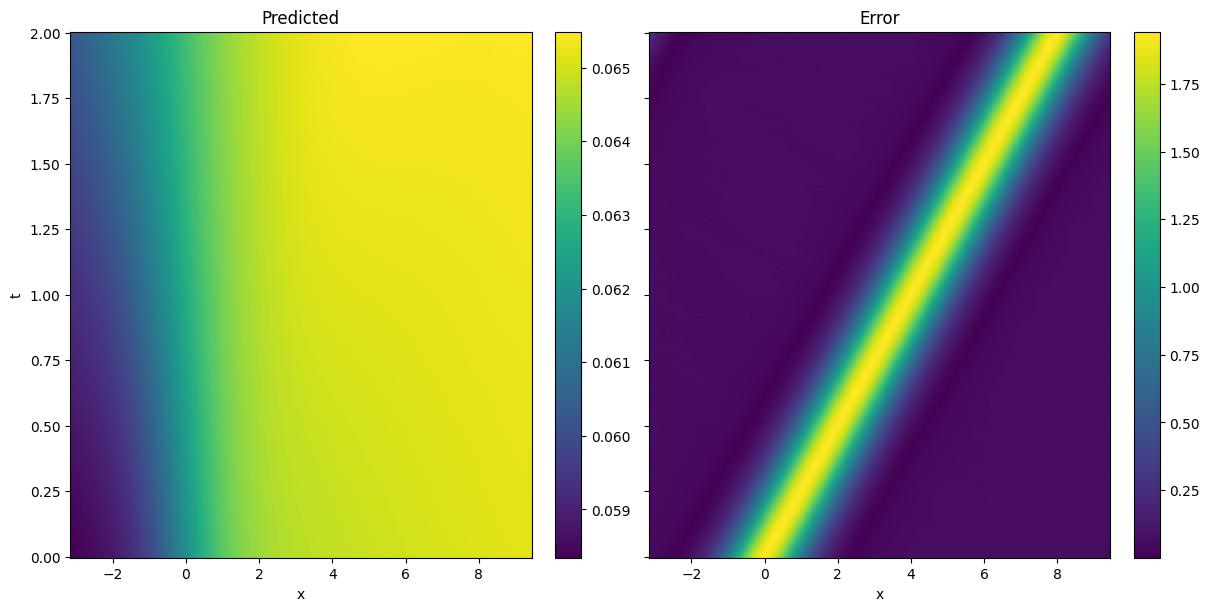

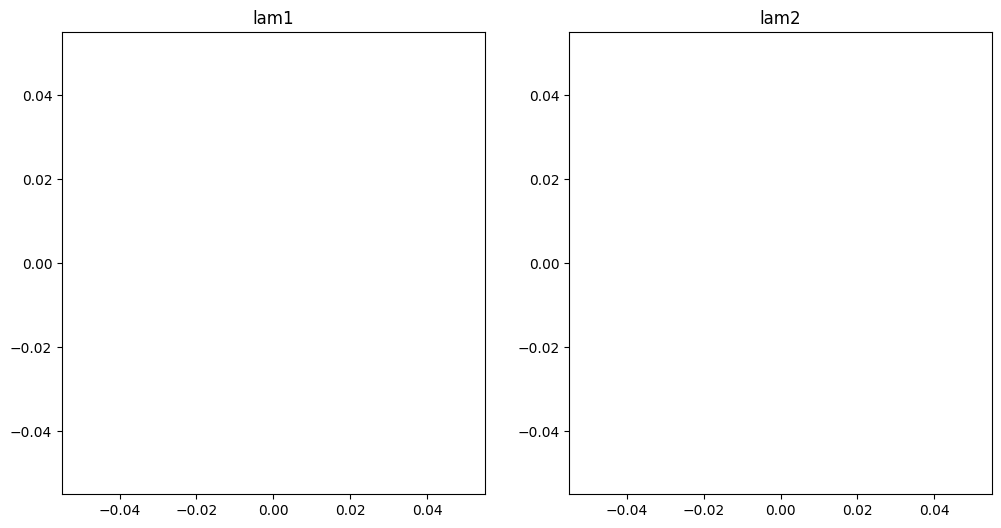

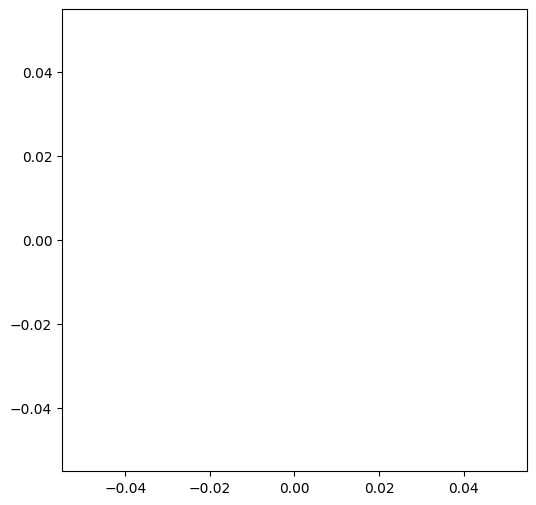

Step: 250, Loss: 0.2840556502342224
Data loss: 0.28343698382377625, Phi loss: 0.0006186665268614888
Lam1: 2.9951, lam2: 0.501
Step: 500, Loss: 0.2434125542640686
Data loss: 0.235697403550148, Phi loss: 0.007715147919952869
Lam1: 2.9969, lam2: 0.4952
Step: 750, Loss: 0.2183205932378769
Data loss: 0.20332138240337372, Phi loss: 0.014999208971858025
Lam1: 3.0027, lam2: 0.4905
Step: 1000, Loss: 0.20715677738189697
Data loss: 0.19110818207263947, Phi loss: 0.016048597171902657
Lam1: 3.0074, lam2: 0.4863
Step: 1250, Loss: 0.19884200394153595
Data loss: 0.1794833093881607, Phi loss: 0.019358688965439796
Lam1: 3.0118, lam2: 0.4818
Step: 1500, Loss: 0.19295178353786469
Data loss: 0.17093105614185333, Phi loss: 0.02202073112130165
Lam1: 3.0159, lam2: 0.4777
Step: 1750, Loss: 0.17452724277973175
Data loss: 0.14612609148025513, Phi loss: 0.028401155024766922
Lam1: 3.0201, lam2: 0.4736
Step: 2000, Loss: 0.14437393844127655
Data loss: 0.10728511959314346, Phi loss: 0.03708881884813309
Lam1: 3.0267, 

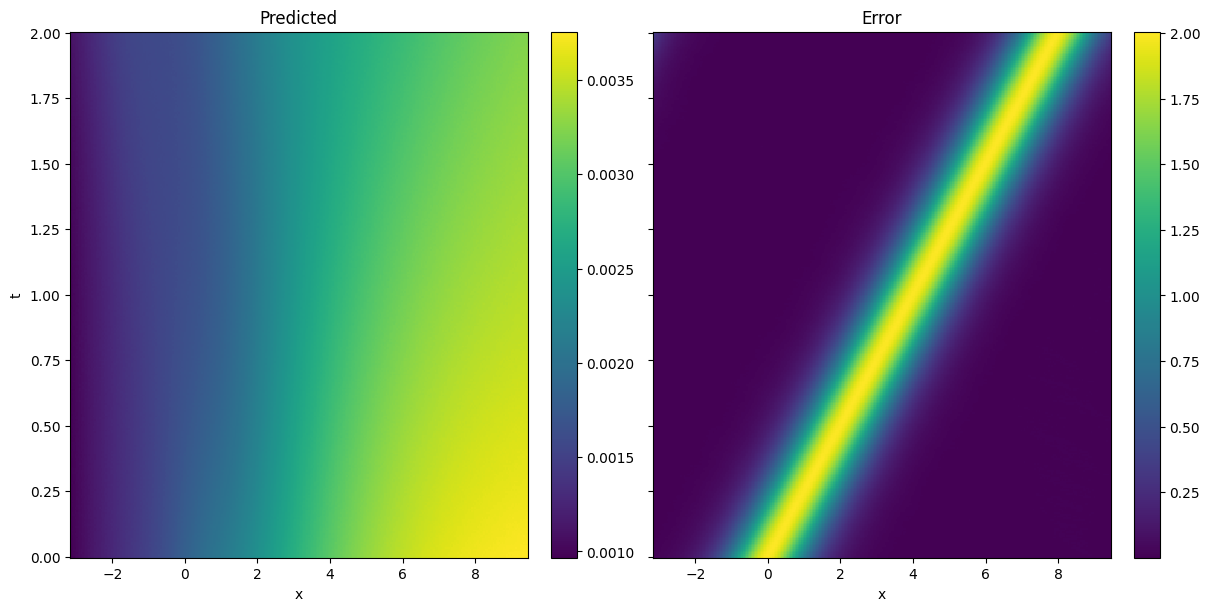

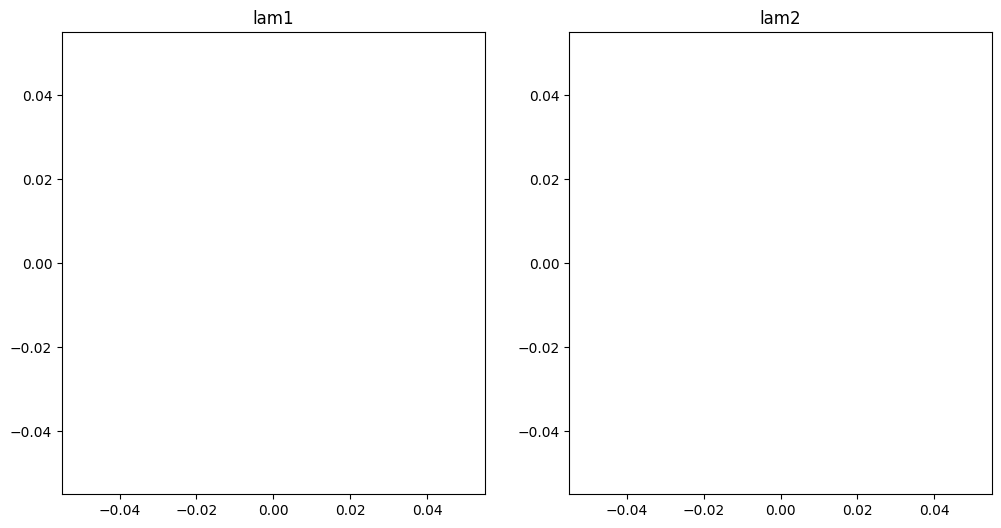

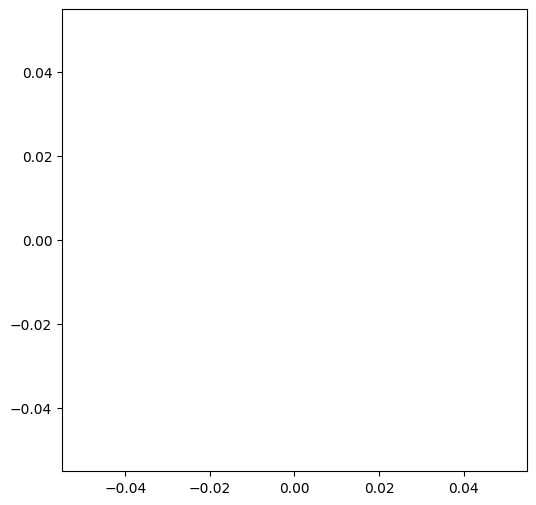

Step: 250, Loss: 0.26004913449287415
Data loss: 0.2565423250198364, Phi loss: 0.003506813431158662
Lam1: 2.9983, lam2: 0.498
Step: 500, Loss: 0.2115144431591034
Data loss: 0.1952591985464096, Phi loss: 0.016255246475338936
Lam1: 3.0039, lam2: 0.4931
Step: 750, Loss: 0.19393961131572723
Data loss: 0.1722215861082077, Phi loss: 0.02171802893280983
Lam1: 3.0085, lam2: 0.4885
Step: 1000, Loss: 0.18400581181049347
Data loss: 0.15840716660022736, Phi loss: 0.025598647072911263
Lam1: 3.0128, lam2: 0.4843
Step: 1250, Loss: 0.1693507730960846
Data loss: 0.13849134743213654, Phi loss: 0.03085942380130291
Lam1: 3.0172, lam2: 0.48
Step: 1500, Loss: 0.15062448382377625
Data loss: 0.11836345493793488, Phi loss: 0.03226103261113167
Lam1: 3.022, lam2: 0.4751
Step: 1750, Loss: 0.13841761648654938
Data loss: 0.1069679781794548, Phi loss: 0.031449638307094574
Lam1: 3.0269, lam2: 0.4697
Step: 2000, Loss: 0.13100552558898926
Data loss: 0.10008618235588074, Phi loss: 0.03091934695839882
Lam1: 3.0311, lam2: 

2         4         6         8         10
0  0.236230  0.207519  0.227246  0.204926  0.204694
1  0.210378  0.163994  0.103295  0.101090  0.099991
2  0.157814  0.095153  0.097031  0.097217  0.098469
3  0.102234  0.095743  0.096402  0.098047  0.100583

In [29]:
df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, phi_train, dDim=dim, nHid=n_layers, lr=1e-5)
        model.train(5000)
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df